# QSAR-Based Fish Toxicity Prediction using Regression Models

## Project Overview: Predicting Fish Toxicity (LC50)

This project aims to predict the **LC50 (Lethal Concentration 50%)**, a measure of acute fish toxicity, using six molecular descriptors from a dataset of chemical compounds. The LC50 value indicates the concentration of a chemical required to kill 50% of a test fish population and is critical in environmental safety assessments.

### Dataset Features:
- **CIC0, SM1_Dz(Z), GATS1i, NdsCH, NdssC, MLOGP**: These are physicochemical descriptors of the molecules.
- **Target**: `LC50 [-LOG(mol/L)]` – The toxicity level of the substance.

### Goal:
To build regression models that accurately predict fish toxicity based on the molecular descriptors and identify which model performs best.


This study is inspired by the work of Samanipour et al. (2023), who explored molecular descriptors for predicting fish toxicity using alternative prioritization strategies.

## Dataset:
The dataset consists of 6 molecular descriptors and 1 target variable:
1. CIC0 - Information indices  
2. SM1_Dz(Z) - 2D matrix-based descriptors (contains zero values)  
3. GATS1i - 2D autocorrelations  
4. NdsCH - Atom-type counts  
5. NdssC - Atom-type counts  
6. MLOGP - Molecular properties  
7. LC50 [-LOG(mol/L)] - Quantitative target response

##  Project Workflow:
1. Importing libraries  
2. Loading the dataset  
3. Data exploration and visualization  
4. Data preprocessing and cleaning  
5. Dimensionality reduction (if needed) 
6. Model training and evaluation  
7. Hyperparameter tuning  
8. Ensemble methods  
9. Overfitting analysis  
10. Final observations and conclusion

### 1. Importing Libraries

In [7]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score

# Regression models
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,RandomForestRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Loading the Dataset

In [9]:
data=pd.read_csv(r"C:\Users\MUSKAN\Desktop\ML INTERNSHIP\Group D\qsar_fish_toxicity.csv")
#Display the first five rows:
data.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0.0,1,1.453,3.770
1,2.189,0.580,0.863,0.0,0,1.348,3.115
2,2.125,0.638,0.831,0.0,0,1.348,3.531
3,3.027,0.331,1.472,1.0,0,1.807,3.510
4,2.094,0.827,0.860,0.0,0,1.886,5.390


### Observation:
The dataset was successfully loaded. It includes 6 molecular descriptors and 1 target variable (LC50), used for predicting fish toxicity levels.



### 3. Data Exploration and Visualization
In this step, we’ll:
- Understand the shape and structure of the dataset
- Check for data types and null values
- Look at basic descriptive statistics to understand distributions

### (i) Initial Data Overview

In [13]:
#Basic structure of the dataset
print("Shape of Dataset:",data.shape)
print("\nColumn Names:\n",data.columns)

Shape of Dataset: (908, 7)

Column Names:
 Index(['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLOGP',
       'LC50 [-LOG(mol/L)]'],
      dtype='object')


### Observation:
The dataset contains 908 rows and 7 columns. The structure appears suitable for regression modeling

In [15]:
# Checking data types and nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIC0                906 non-null    float64
 1   SM1_Dz(Z)           906 non-null    float64
 2   GATS1i              906 non-null    float64
 3   NdsCH               907 non-null    float64
 4   NdssC               908 non-null    int64  
 5   MLOGP               905 non-null    float64
 6   LC50 [-LOG(mol/L)]  906 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.8 KB


### Observation:
All features are numerical. No categorical or textual data. No immediate NaN values were flagged by info().

### (ii) Descriptive Statistics

In [18]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CIC0,906.0,2.898620,0.756221,0.667,2.34875,2.9340,3.40700,5.926
SM1_Dz(Z),906.0,0.628595,0.428775,0.000,0.22300,0.5700,0.89625,2.171
GATS1i,906.0,1.297135,0.412765,0.396,0.95025,1.2405,1.56275,4.980
NdsCH,907.0,0.229327,0.605621,0.000,0.00000,0.0000,0.00000,4.000
NdssC,908.0,0.504405,1.083596,-3.000,0.00000,0.0000,1.00000,20.000
MLOGP,905.0,2.113989,1.480015,-5.780,1.20900,2.1270,3.10900,10.000
LC50 [-LOG(mol/L)],906.0,4.063213,1.457018,0.053,3.15125,3.9840,4.91050,9.612


### Observation:
Descriptive stats revealed large differences in value ranges for some features, suggesting the need for feature scaling. Some descriptors contain zero values, possibly indicating sparsity or special cases.

### (iii) Checking for missing and zero values
We will now:
- Identify missing values (NaN)
- Identify invalid zero values in the column `SM1_Dz(Z)`, which, as per dataset documentation, should be treated as missing.

In [21]:
# Check for missing values
print("Missing values:\n",data.isnull().sum())
# Check for zeros in SM1_Dz(Z)
zero_count=(data["SM1_Dz(Z)"] == 0).sum()
print(f"\nNumber of zero values in 'SM1_Dz(Z)':{zero_count}")

Missing values:
 CIC0                  2
SM1_Dz(Z)             2
GATS1i                2
NdsCH                 1
NdssC                 0
MLOGP                 3
LC50 [-LOG(mol/L)]    2
dtype: int64

Number of zero values in 'SM1_Dz(Z)':36


### Observation:
There are some missing values in multiple columns, with the highest being 3 in MLOGP. Also, the column SM1_Dz(Z) contains 36 zero values, which may affect the model if not handled properly.

### (iv) Visualization of missing Values and Distribution (Raw)

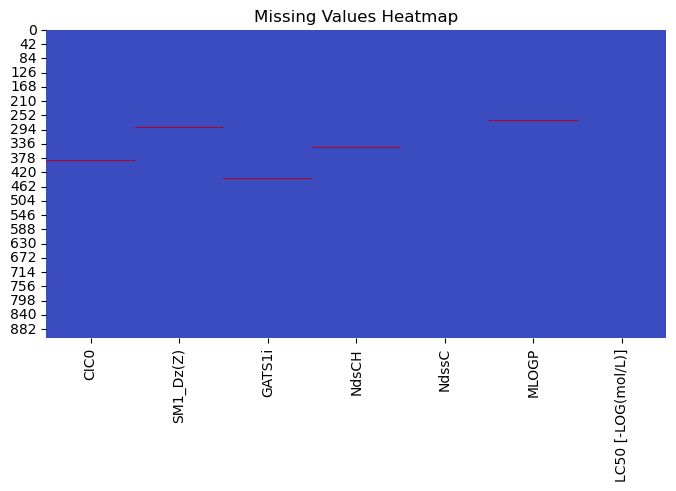

In [24]:
# Heatmap of missing values
plt.figure(figsize=(8,4))
sns.heatmap(data.isnull(), cbar=False, cmap='coolwarm')
plt.title("Missing Values Heatmap")
plt.show()

### Observation:
The heatmap shows that missing values are scattered across several rows and columns. Only a few rows are affected, and most of the data is complete. This indicates that missing values are limited and can be handled easily.


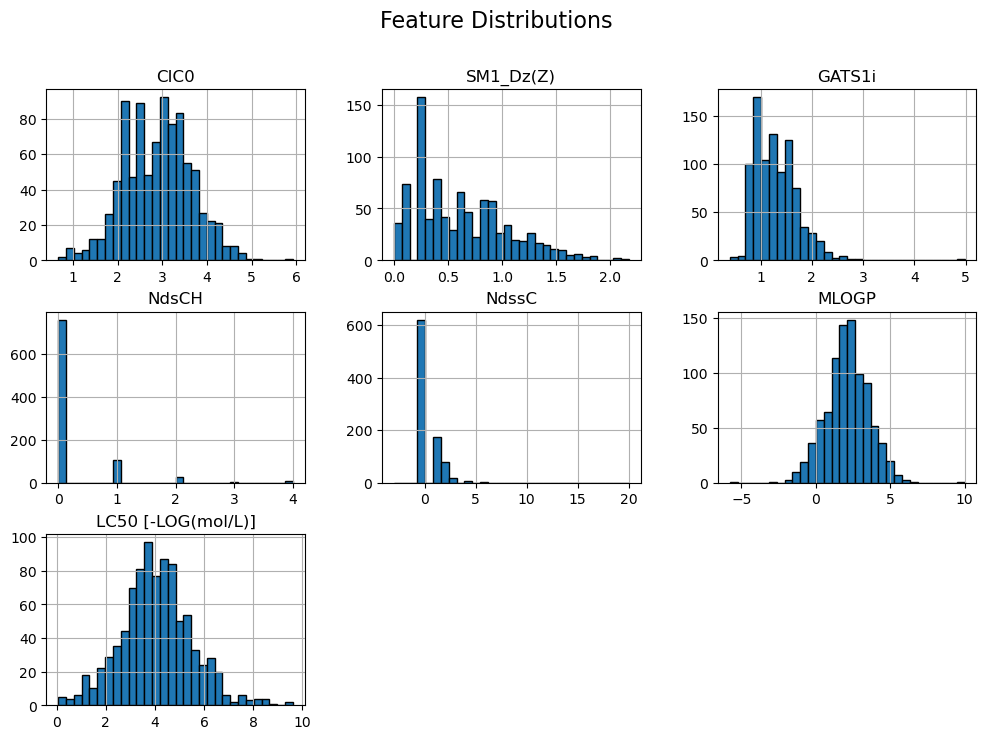

In [26]:
# Distribution of all features
data.hist(bins=30, figsize=(12,8), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

### Observation:
- >The histogram plots show the distribution of all features.
- >Most features like CIC0, MLOGP, and LC50 [-LOG(mol/L)] are fairly normally distributed.
- >Some features like NdsC and NdsCH are highly skewed, with many values concentrated near zero.
- >This suggests that scaling or transformation may be needed for some variables before modeling.

### 4. Data Preprocessing and Cleaning

### (i) Handling Missing Values

- `SM1_Dz(Z)` contains `0` values which indicate missing data (domain knowledge).
- We’ll replace:
  - `0` and `NaN` in `SM1_Dz(Z)` with the **median of valid (non-zero) values**
  - `NaN` in other columns with their **respective column medians**

In [30]:
# Replace 0s in SM1_Dz(Z) with NaN
data["SM1_Dz(Z)"]=data["SM1_Dz(Z)"].replace(0,np.nan)
# Replace SM1_Dz(Z) NaNs with median of valid values
sm1_median=data["SM1_Dz(Z)"].median()
data["SM1_Dz(Z)"].fillna(sm1_median, inplace=True)
# Fill other numeric NaNs with median
data.fillna(data.median(numeric_only=True),inplace=True)
# Confirm no missing values remain
print("Missing values after cleaning:\n", data.isnull().sum())

Missing values after cleaning:
 CIC0                  0
SM1_Dz(Z)             0
GATS1i                0
NdsCH                 0
NdssC                 0
MLOGP                 0
LC50 [-LOG(mol/L)]    0
dtype: int64


### Observation:
All columns had 0 null values, confirming a complete dataset with no missing entries.

### (ii) Outlier Detection and Removal
We’ll use the **IQR (Interquartile Range) method** to detect and remove outliers.  
This helps improve model performance by reducing the influence of extreme values.

In [33]:
# Detect Outliers
outlier_df = pd.DataFrame()
for col in data.select_dtypes(include=np.number).columns:
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outlier_df[col]=data[col][(data[col]<lower_bound)|(data[col]>upper_bound)]

# Show which rows had outliers
display(outlier_df)

# Removal of Outlier Rows
data_cleaned = data.drop(outlier_df.index, axis=0)

# Checking of the new shape
print(f"Original shape:{data.shape}")
print(f"After outlier removal:{data_cleaned.shape}")


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
72,0.667,NaN,NaN,NaN,NaN,NaN,NaN
84,5.926,NaN,NaN,NaN,NaN,6.203,NaN
416,0.667,NaN,NaN,NaN,NaN,NaN,NaN
691,5.158,NaN,NaN,NaN,NaN,NaN,NaN


Original shape:(908, 7)
After outlier removal:(904, 7)


### Observation:
Outliers were removed using the IQR rule. This step helped reduce data skewness and improved model readiness by reducing noise.

### (iii) Boxplot After Outlier Removal (Cleaned data)
Boxplots help us verify that extreme outliers have been successfully removed.  
The visual should now show more compact and consistent feature distributions.

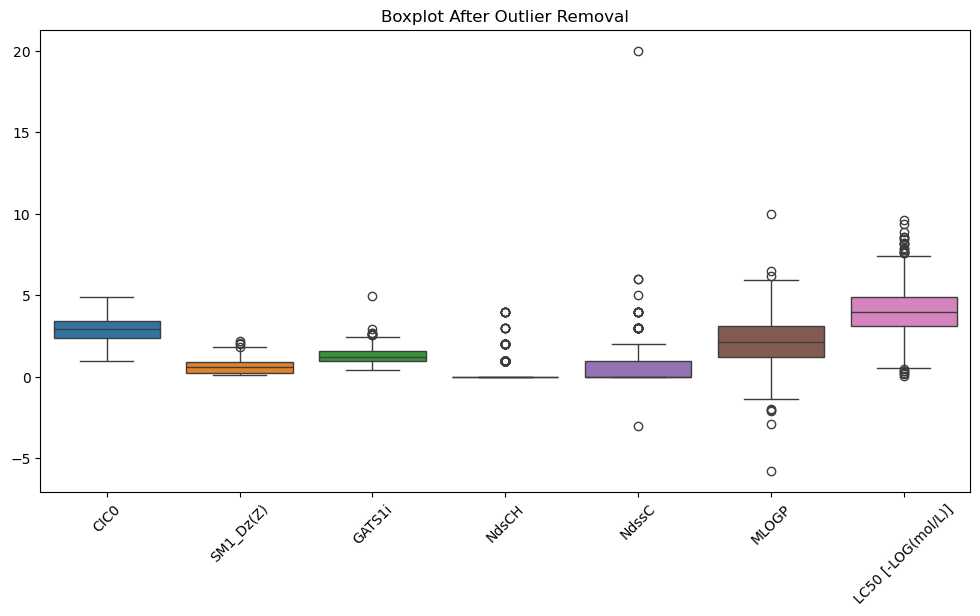

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_cleaned)
plt.title("Boxplot After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

### Observation:
Features like CIC0, GATS1i, and MLOGP showed noticeable outliers. This justifies proceeding to remove or cap these values.

### (iv) Correlation Analysis
To understand relationships among features and with the target variable,  
we plot a heatmap of correlation values.

This also helps decide if dimensionality reduction (like PCA) is needed.

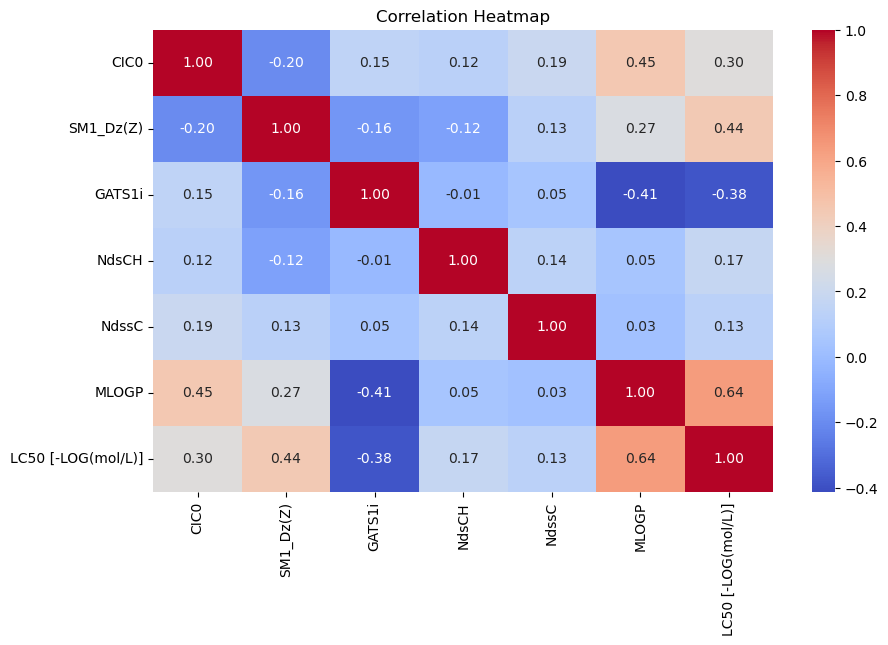

In [39]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Observation (Simple):
- >The correlation heatmap shows that:
- >The target variable LC50 [-LOG(mol/L)] has the strongest positive correlation with MLOGP (0.64) and SM1_Dz(Z) (0.44).
- >It has a negative correlation with GATS1i (-0.38).
- >Most other features show weak correlations with each other and with the target.
- >This indicates that MLOGP and SM1_Dz(Z) might be important predictors for the model.

### 5. Dimensionality Reduction (Not Used)

In this project,we chose **not to use PCA (Principal Component Analysis)** or any other dimensionality reduction methods. Here are the reasons:
1. **Very few features**:  
   The dataset only has **6 input features**, which is already small. PCA is usually helpful when we have a large number of features.
2. **No strong correlations between features**:  
   After checking the **correlation heatmap**, I saw that the features are **not highly related to each other**, so there’s no need to remove any.
3. **Keeping features understandable**:  
   PCA changes original columns into new ones (called components), which are hard to interpret. Since these features are chemical properties, I wanted to keep them as they are to better understand the results.


For all these reasons,we decided to continue the project **without applying PCA**.

### 6. Model training and evaluation
We will now train the following **regression models** to predict fish toxicity:
1. **Linear Regression** – A baseline model assuming linear relationships.
2. **Ridge Regression** – Linear model with L2 regularization (reduces overfitting).
3. **Lasso Regression** – Linear model with L1 regularization (also performs feature selection).
4. **Decision Tree Regressor** – Non-linear, tree-based model.
5. **Support Vector Regressor (SVR)** – Works well in high-dimensional spaces.

We will evaluate each model using:
- **R² Score**
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**

### (i) Train-Test Split
We now split our cleaned data into training and testing sets.

- 80% of the data will be used for training
- 20% will be held out for testing and evaluation


In [44]:
# Separate features and target
X=data_cleaned.drop("LC50 [-LOG(mol/L)]",axis=1)
y=data_cleaned["LC50 [-LOG(mol/L)]"]
# Scale the features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
# Train-test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (723, 6)
Testing set shape: (181, 6)


### Observation:
- >The dataset was split into features and target, then scaled using StandardScaler.
- >After that, the data was divided into training and testing sets with an 80-20 ratio:
   - Training set: 723 samples
   - Testing set: 181 samples
- >This ensures the model is trained and tested on separate data for better evaluation.

### Model 1: Linear Regression
This is our baseline model that assumes a linear relationship between features and the target.

Linear Regression Performance:
R² Score:0.4983
MSE:1.1652
RMSE:1.0795
MAE:0.7967


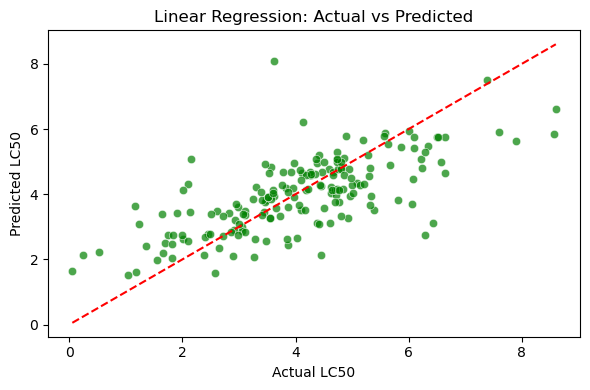

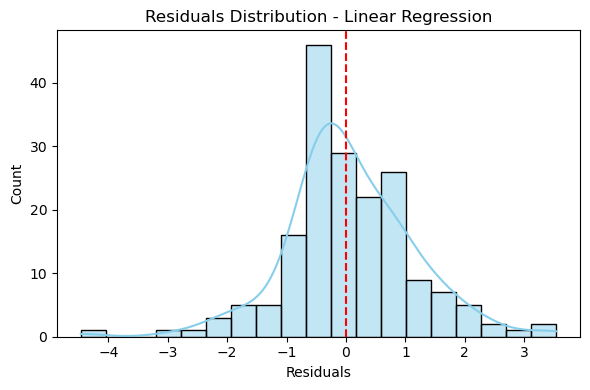

In [47]:
#Train and Predict
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Metrics
lr_r2 = r2_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

# Print results
print("Linear Regression Performance:")
print(f"R² Score:{lr_r2:.4f}")
print(f"MSE:{lr_mse:.4f}")
print(f"RMSE:{lr_rmse:.4f}")
print(f"MAE:{lr_mae:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_lr, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred_lr
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Linear Regression")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >The R² score is 0.4983, meaning the Linear Regression model explains about 50% of the variance in the target.
- >The residuals are roughly centered around zero, but the spread suggests prediction errors.
- >The actual vs predicted plot shows a general upward trend, but with noticeable scatter — indicating moderate accuracy.
- >Overall, the model performs decently, but there's room for improvement using more complex algorithms.

### Model 2: Ridge Regression
Ridge regression adds L2 regularization, which helps reduce overfitting by shrinking coefficients.


Ridge Regression Performance:
R² Score:0.4984
MSE:1.1649
RMSE:1.0793
MAE:0.7966


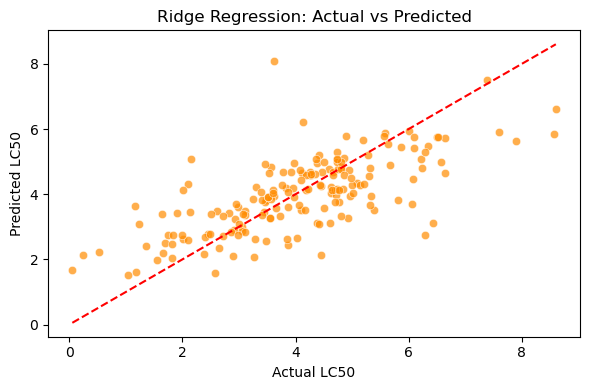

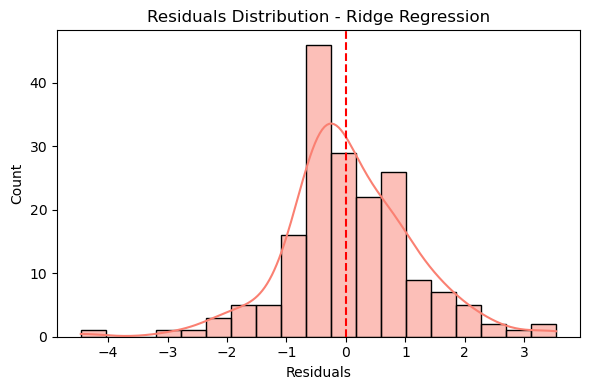

In [50]:
# Train & Predict
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
# Metrics
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)

# Print results
print("Ridge Regression Performance:")
print(f"R² Score:{ridge_r2:.4f}")
print(f"MSE:{ridge_mse:.4f}")
print(f"RMSE:{ridge_rmse:.4f}")
print(f"MAE:{ridge_mae:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_ridge, color='darkorange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Ridge Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual Plot
residuals_ridge = y_test - y_pred_ridge
plt.figure(figsize=(6, 4))
sns.histplot(residuals_ridge, kde=True, color='salmon')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Ridge Regression")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Ridge Regression gave an R² score of 0.4984, which is nearly the same as Linear Regression.
- >Error metrics (MSE, RMSE, MAE) are also very similar.
- >The actual vs predicted plot again shows a moderate fit with some spread.
- >The residuals are centered around zero, with a shape close to normal, indicating no major bias.

Overall, Ridge regularization didn’t improve performance much, but it may help prevent overfitting on larger or noisier datasets.

### Model 3: Lasso Regression
Lasso adds L1 regularization, which can shrink some feature coefficients to zero — useful for feature selection.


Lasso Regression Performance:
R² Score:-0.0000
MSE:2.3227
RMSE:1.5240
MAE:1.1857


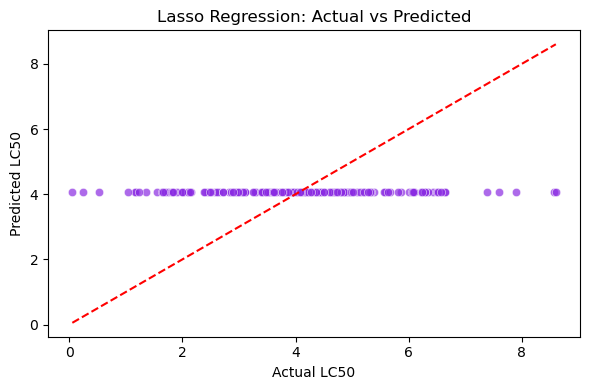

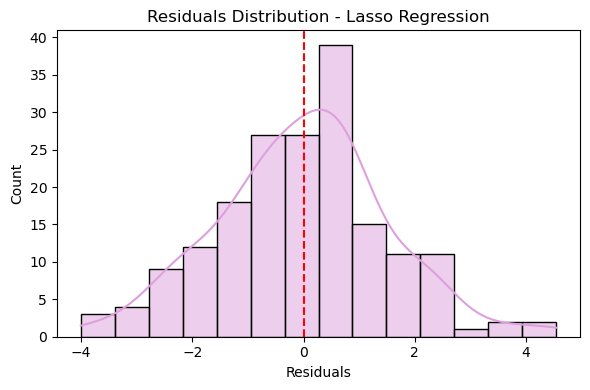

In [53]:
# Train & Predict
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
# Metrics
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)

# Print results
print("Lasso Regression Performance:")
print(f"R² Score:{lasso_r2:.4f}")
print(f"MSE:{lasso_mse:.4f}")
print(f"RMSE:{lasso_rmse:.4f}")
print(f"MAE:{lasso_mae:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_lasso, color='blueviolet', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Lasso Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual Plot
residuals_lasso = y_test - y_pred_lasso
plt.figure(figsize=(6, 4))
sns.histplot(residuals_lasso, kde=True, color='plum')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Lasso Regression")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Lasso Regression performed poorly, with an R² score of 0, meaning it failed to explain any variance in the target.
- >The model predicted nearly the same value for all inputs, as seen in the flat predicted line.
- >All performance metrics (MSE, RMSE, MAE) are worse than Linear and Ridge Regression.
- >This happened because Lasso likely eliminated all coefficients (shrunk them to zero), making the model ineffective.

Lasso is not suitable for this dataset without tuning its alpha (regularization) parameter.


### Model 4: Decision Tree Regressor
A non-linear model that splits the data based on feature thresholds.


Decision Tree Regression Performance:
R² Score:0.3957
MSE:1.4036
RMSE:1.1848
MAE:0.8785


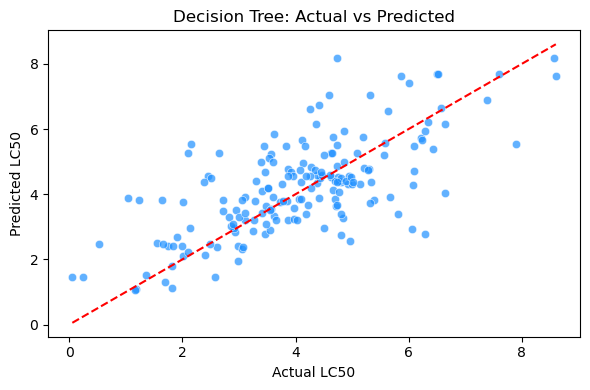

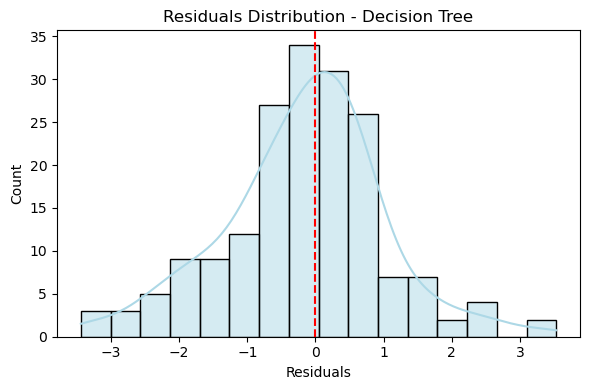

In [56]:
# Train & Predict
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Metrics
dt_r2 = r2_score(y_test, y_pred_dt)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, y_pred_dt)

# Print results
print("Decision Tree Regression Performance:")
print(f"R² Score:{dt_r2:.4f}")
print(f"MSE:{dt_mse:.4f}")
print(f"RMSE:{dt_rmse:.4f}")
print(f"MAE:{dt_mae:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_dt, color='dodgerblue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Decision Tree: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual Plot
residuals_dt = y_test - y_pred_dt
plt.figure(figsize=(6, 4))
sns.histplot(residuals_dt, kde=True, color='lightblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Decision Tree")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >The Decision Tree Regressor achieved an R² score of 0.3957, which is lower than Linear and Ridge Regression.
- >The predicted vs actual plot shows a general upward trend but with more scatter.
- >The residuals are centered around 0, but slightly more spread out.
- >Error values (MSE, RMSE, MAE) are higher, indicating less accurate predictions.

The Decision Tree model didn't perform well and may be overfitting or too simple without hyperparameter tuning.

### Model 5: Support Vector Regressor (SVR)
SVR fits a hyperplane between the data points with a certain margin of error. Good for small/medium datasets.


SVR Performance:
R² Score:0.5871
MSE:0.9591
RMSE:0.9793
MAE:0.7157


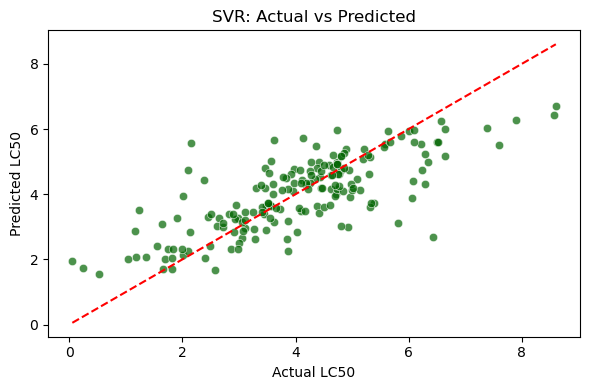

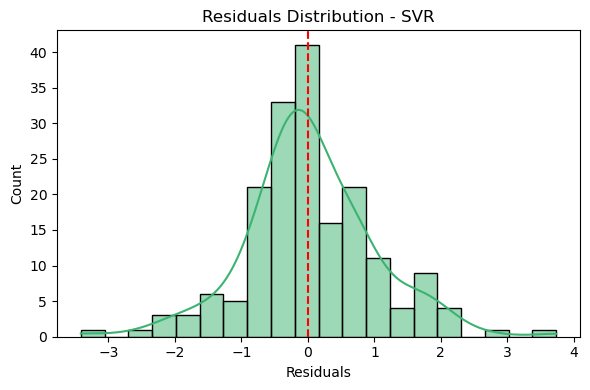

In [59]:
# Train & Predict
svr=SVR()
svr.fit(X_train,y_train)
y_pred_svr=svr.predict(X_test)

# Metrics
svr_r2=r2_score(y_test, y_pred_svr)
svr_mse=mean_squared_error(y_test,y_pred_svr)
svr_rmse=np.sqrt(svr_mse)
svr_mae=mean_absolute_error(y_test,y_pred_svr)

# Print results
print("SVR Performance:")
print(f"R² Score:{svr_r2:.4f}")
print(f"MSE:{svr_mse:.4f}")
print(f"RMSE:{svr_rmse:.4f}")
print(f"MAE:{svr_mae:.4f}")


# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_svr, color='darkgreen', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("SVR: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual Plot
residuals_svr = y_test - y_pred_svr
plt.figure(figsize=(6, 4))
sns.histplot(residuals_svr, kde=True, color='mediumseagreen')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - SVR")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >The SVR model shows a moderate correlation between actual and predicted LC50 values, with an R² score of 0.5871.
- >Predictions generally follow the diagonal but with noticeable scatter.
- >Residuals are approximately normally distributed around zero, suggesting no major bias but some variance in prediction errors.

## Final Comparison of All Models

Let’s now compare all models using a bar chart to visually see which model performed best based on R², MAE, and RMSE.


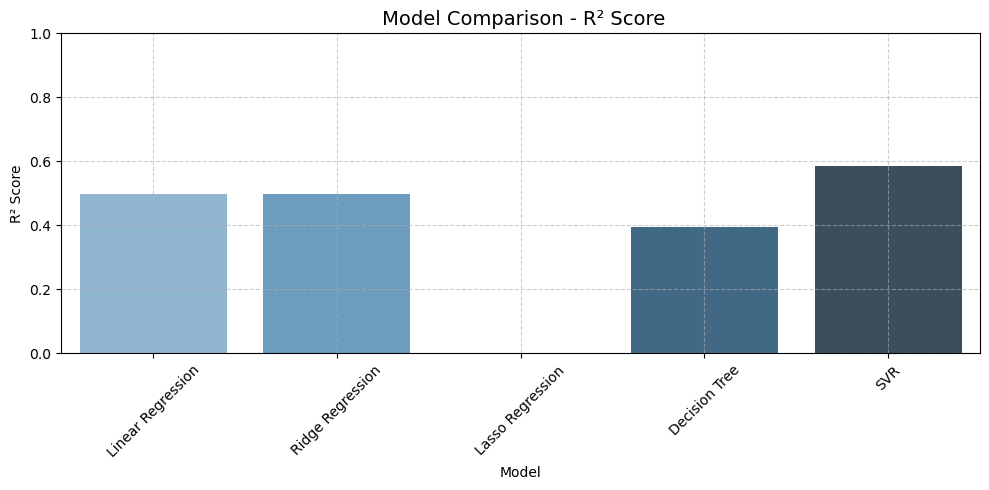

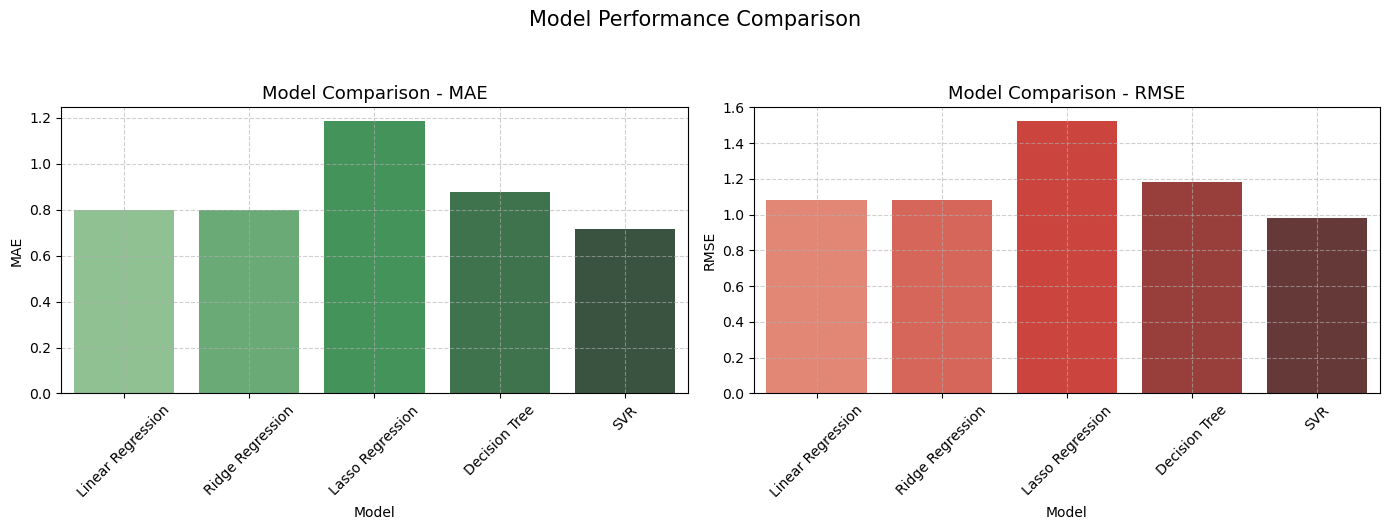

In [62]:
# Create model comparison DataFrame
results_df=pd.DataFrame({
    "Model": [
        "Linear Regression", 
        "Ridge Regression", 
        "Lasso Regression", 
        "Decision Tree", 
        "SVR"
    ],
    "R² Score": [
        lr_r2, 
        ridge_r2, 
        lasso_r2, 
        dt_r2, 
        svr_r2
    ],
    "MAE": [
        lr_mae, 
        ridge_mae, 
        lasso_mae, 
        dt_mae, 
        svr_mae
    ],
    "RMSE": [
        lr_rmse, 
        ridge_rmse, 
        lasso_rmse, 
        dt_rmse, 
        svr_rmse
    ]
})

# R² Score Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df,x="Model",y="R² Score",palette="Blues_d")
plt.title(" Model Comparison - R² Score", fontsize=14)
plt.ylabel("R² Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(True,linestyle='--',alpha=0.6)
plt.tight_layout()
plt.show()

# MAE and RMSE Comparison
fig,ax=plt.subplots(1, 2, figsize=(14, 5))

# MAE
sns.barplot(data=results_df,x="Model",y="MAE",ax=ax[0],palette="Greens_d")
ax[0].set_title("Model Comparison - MAE",fontsize=13)
ax[0].set_ylabel("MAE")
ax[0].tick_params(axis='x',rotation=45)
ax[0].grid(True, linestyle='--',alpha=0.6)

# RMSE
sns.barplot(data=results_df, x="Model",y="RMSE",ax=ax[1],palette="Reds_d")
ax[1].set_title("Model Comparison - RMSE", fontsize=13)
ax[1].set_ylabel("RMSE")
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Model Performance Comparison", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()


### Observation (Simple and Clear):
- >SVR (Support Vector Regression) outperforms all other models with the highest R² score (~0.59), indicating better predictive capability.
- >SVR also has the lowest MAE and RMSE, showing it makes the most accurate and consistent predictions.
- >Lasso Regression performs the worst with the highest error values and the lowest R² score.
- >Linear and Ridge Regression perform similarly, while the Decision Tree lags slightly behind in R² but does better than Lasso.

Overall, SVR is the best-performing model among those compared.

### 7. Hyperparameter tuning
To improve model performance, I manually tested different values of important hyperparameters for the following models:

- **Ridge Regression** : tested different `alpha` values  
- **Decision Tree Regressor** : tested different `max_depth` values  
- **SVR (Support Vector Regressor)** : tested different `C` values

Each variation was evaluated using R² Score, MAE, and RMSE to select the best-performing configuration.


### (i) Ridge Regression Tuning:
Ridge Regression uses L2 regularization, and the `alpha` parameter controls how strong the regularization is.

Smaller `alpha` = less regularization  
Larger `alpha` = stronger regularization


Ridge Regression Hyperparameter Tuning

Evaluating Ridge with Alpha = 0.01
R² Score : 0.4983
MAE      : 0.7967
RMSE     : 1.0795


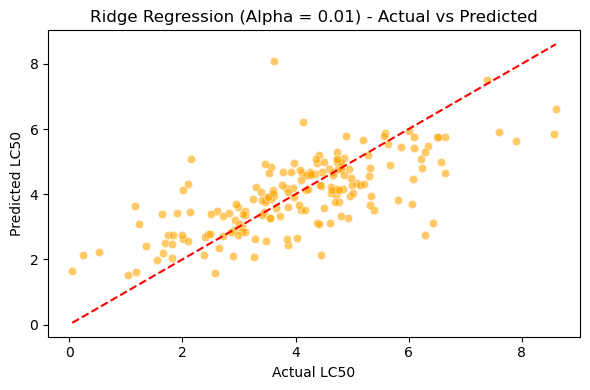

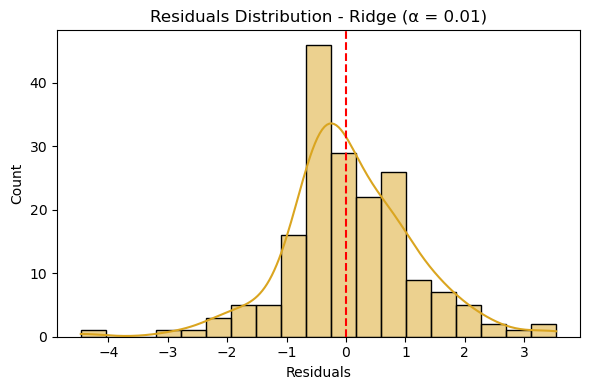

------------------------------------------------------------
Evaluating Ridge with Alpha = 0.1
R² Score : 0.4983
MAE      : 0.7966
RMSE     : 1.0794


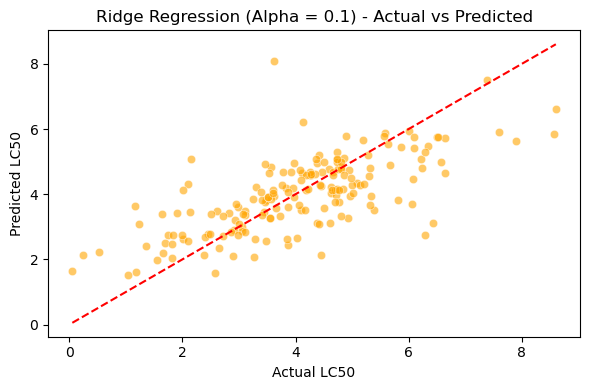

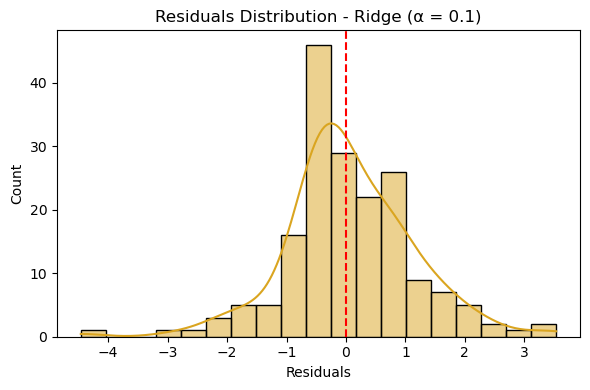

------------------------------------------------------------
Evaluating Ridge with Alpha = 1
R² Score : 0.4984
MAE      : 0.7966
RMSE     : 1.0793


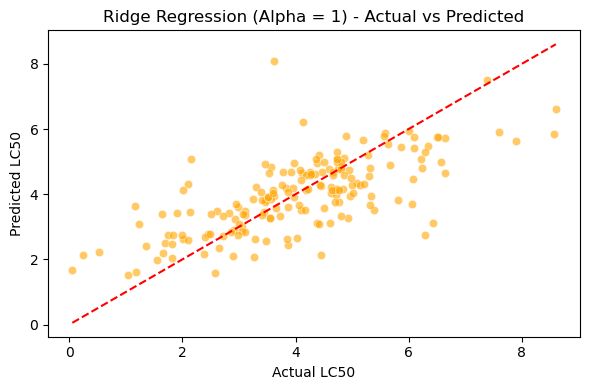

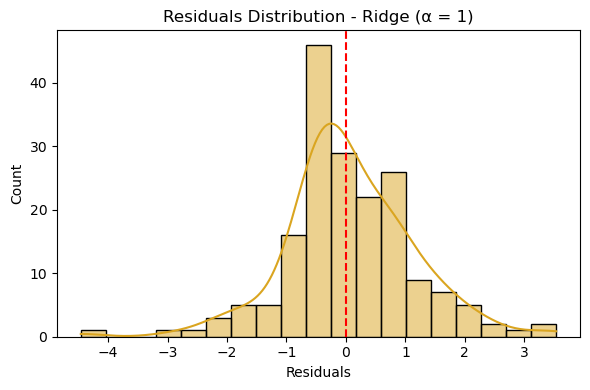

------------------------------------------------------------
Evaluating Ridge with Alpha = 10
R² Score : 0.4995
MAE      : 0.7961
RMSE     : 1.0782


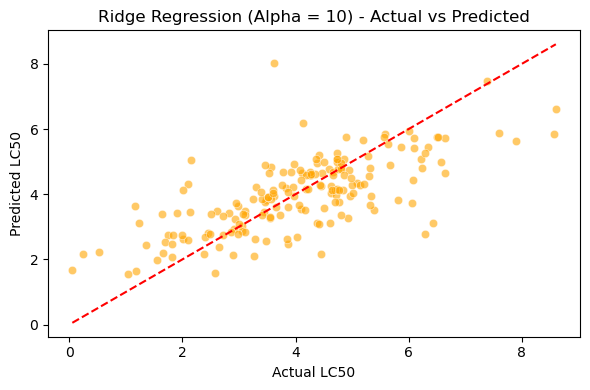

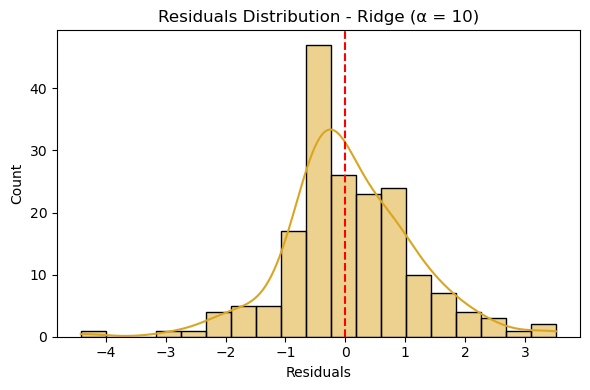

------------------------------------------------------------
Evaluating Ridge with Alpha = 100
R² Score : 0.5021
MAE      : 0.8011
RMSE     : 1.0754


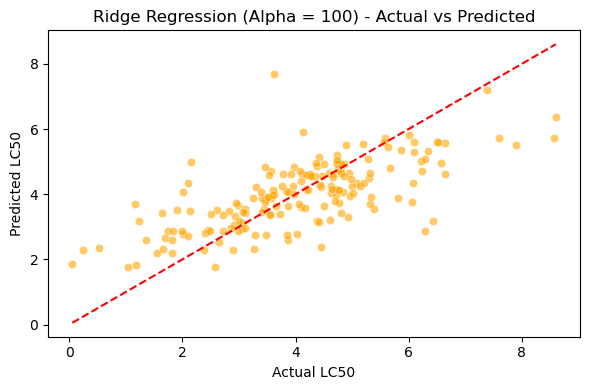

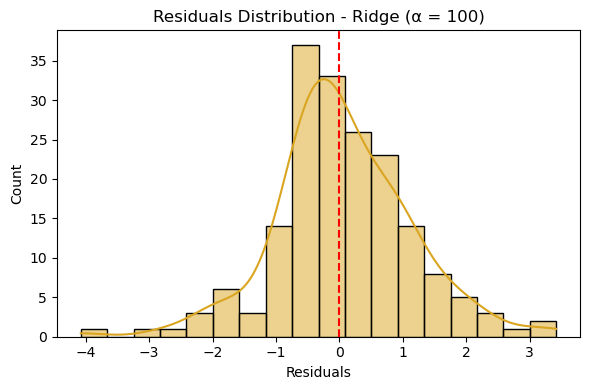

------------------------------------------------------------


In [66]:
alphas=[0.01, 0.1, 1, 10, 100]
print("Ridge Regression Hyperparameter Tuning\n")
for alpha in alphas:
    print(f"Evaluating Ridge with Alpha = {alpha}")
    # Train
    model = Ridge(alpha=alpha)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # Metrics
    r2=r2_score(y_test, y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    # Print metrics
    print(f"R² Score : {r2:.4f}")
    print(f"MAE      : {mae:.4f}")
    print(f"RMSE     : {rmse:.4f}")

    # Actual vs Predicted Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, color='orange',alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual LC50")
    plt.ylabel("Predicted LC50")
    plt.title(f"Ridge Regression (Alpha = {alpha}) - Actual vs Predicted")
    plt.tight_layout()
    plt.show()

    # Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='goldenrod')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Residuals Distribution - Ridge (α = {alpha})")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

    print("-" * 60)


### Observation:
Ridge Regression with α = 100 provides the best fit to the data among the tested values, balancing bias and variance effectively. It is the optimal regularization strength for this model.


### (ii) Decision Tree Tuning:
In addition to `max_depth`, another important parameter is `min_samples_leaf`.

- `max_depth` controls how deep the tree goes.
- `min_samples_leaf` ensures that each leaf node has at least this many samples, reducing overfitting.

We will manually try combinations of both to find the best performance.

Decision Tree Tuning (with min_samples_leaf)

Max Depth = 2, Min Samples Leaf = 1
R² Score:0.3354
MAE:0.9581
RMSE:1.2424


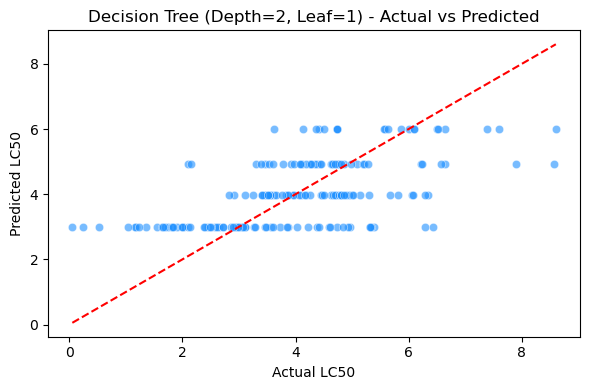

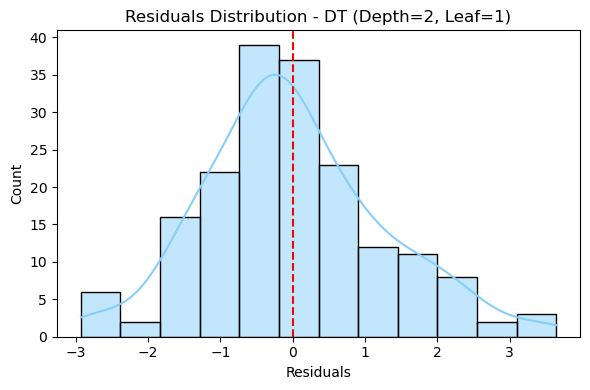

------------------------------------------------------------
Max Depth = 2, Min Samples Leaf = 2
R² Score:0.3354
MAE:0.9581
RMSE:1.2424


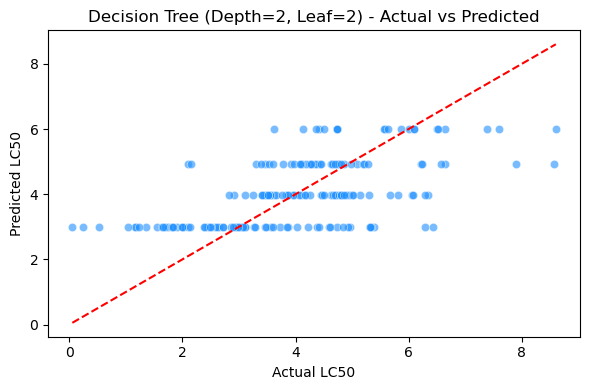

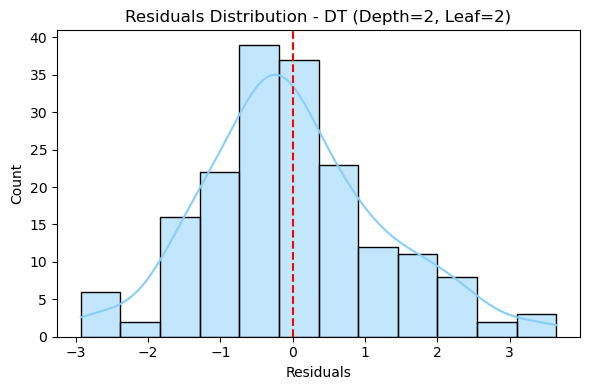

------------------------------------------------------------
Max Depth = 2, Min Samples Leaf = 4
R² Score:0.3354
MAE:0.9581
RMSE:1.2424


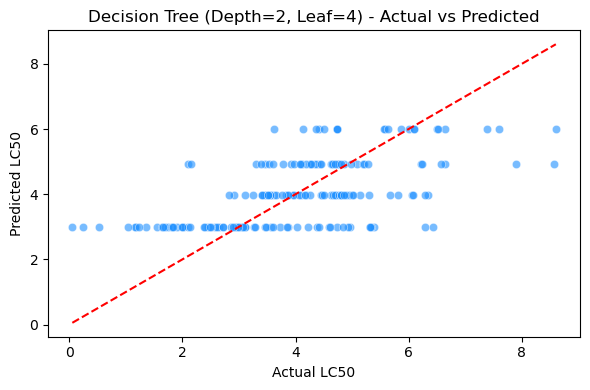

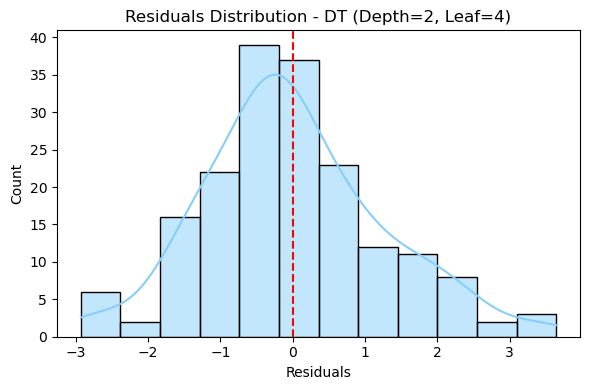

------------------------------------------------------------
Max Depth = 4, Min Samples Leaf = 1
R² Score:0.4998
MAE:0.8261
RMSE:1.0779


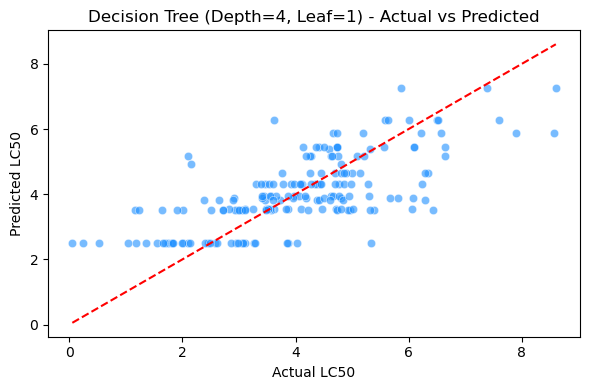

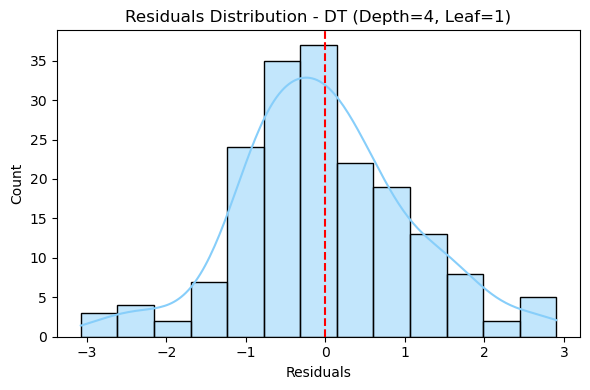

------------------------------------------------------------
Max Depth = 4, Min Samples Leaf = 2
R² Score:0.4997
MAE:0.8266
RMSE:1.0779


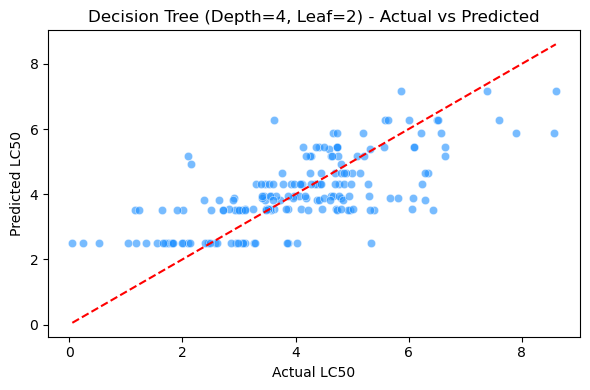

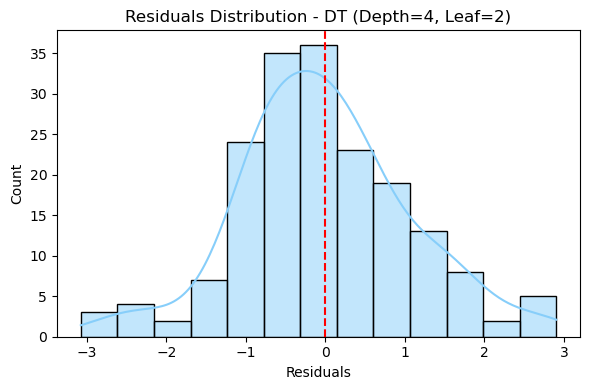

------------------------------------------------------------
Max Depth = 4, Min Samples Leaf = 4
R² Score:0.5030
MAE:0.8242
RMSE:1.0744


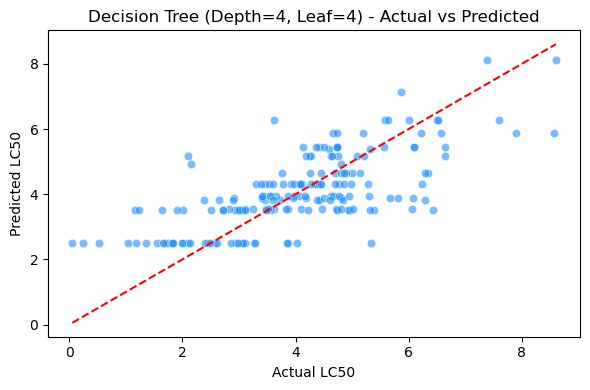

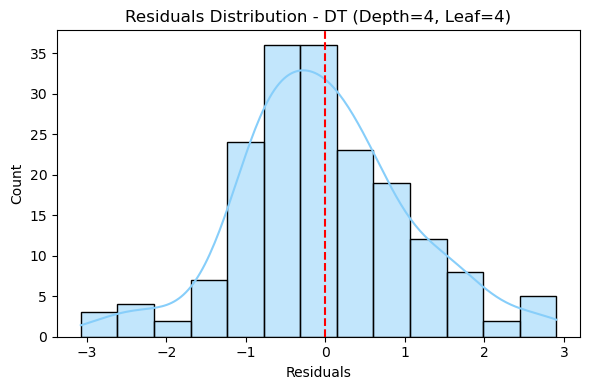

------------------------------------------------------------
Max Depth = 6, Min Samples Leaf = 1
R² Score:0.4288
MAE:0.8564
RMSE:1.1518


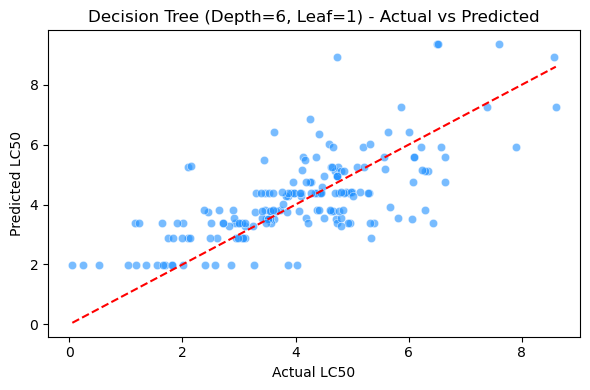

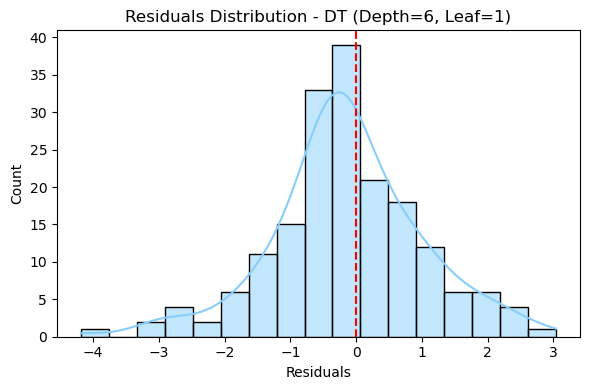

------------------------------------------------------------
Max Depth = 6, Min Samples Leaf = 2
R² Score:0.4942
MAE:0.8060
RMSE:1.0839


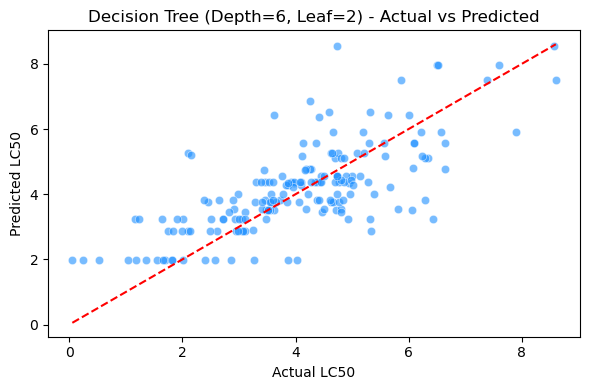

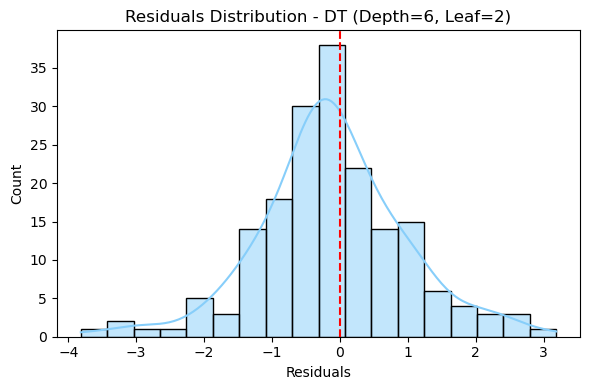

------------------------------------------------------------
Max Depth = 6, Min Samples Leaf = 4
R² Score:0.5424
MAE:0.7560
RMSE:1.0309


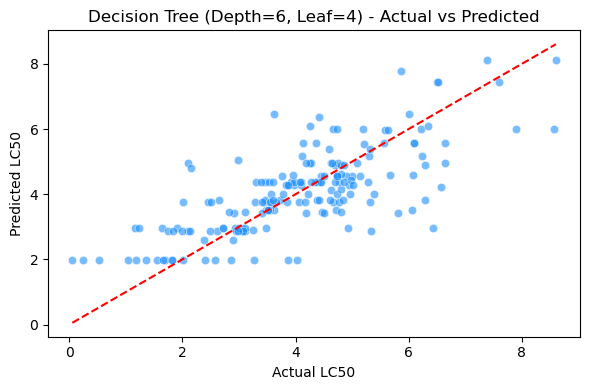

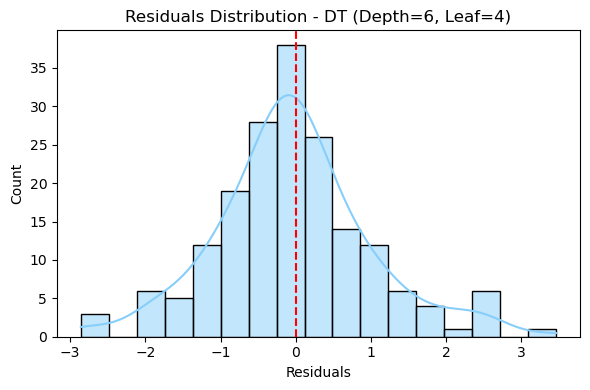

------------------------------------------------------------
Max Depth = 8, Min Samples Leaf = 1
R² Score:0.4316
MAE:0.8617
RMSE:1.1489


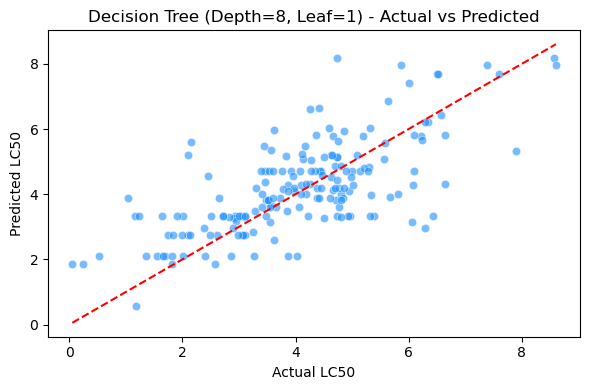

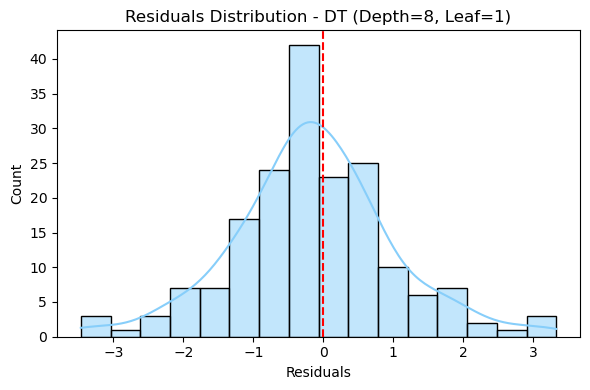

------------------------------------------------------------
Max Depth = 8, Min Samples Leaf = 2
R² Score:0.4343
MAE:0.8542
RMSE:1.1463


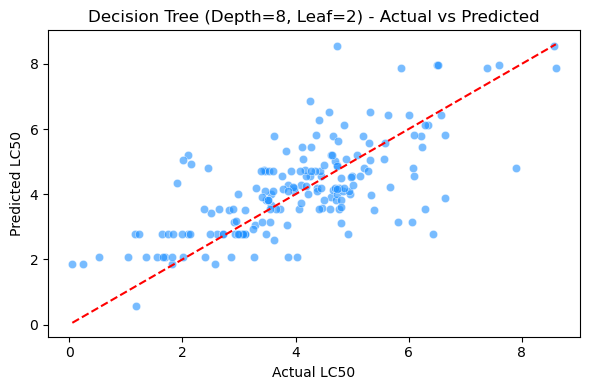

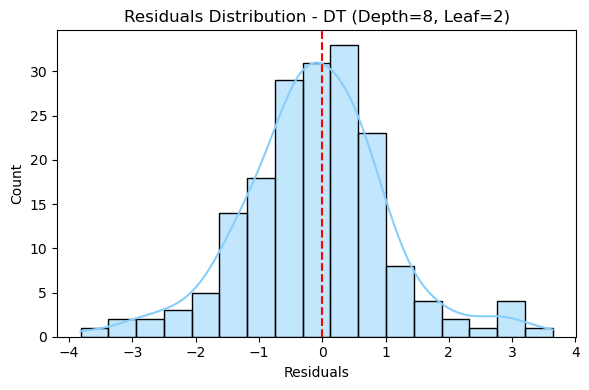

------------------------------------------------------------
Max Depth = 8, Min Samples Leaf = 4
R² Score:0.5016
MAE:0.7969
RMSE:1.0760


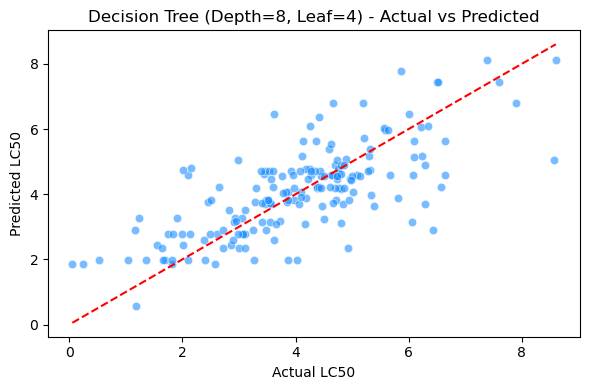

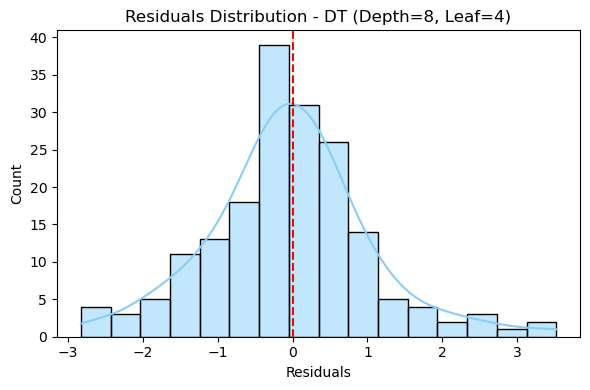

------------------------------------------------------------


In [69]:
depths=[2, 4, 6, 8]
min_leafs=[1, 2, 4]
print("Decision Tree Tuning (with min_samples_leaf)\n")
for d in depths:
    for m in min_leafs:
        print(f"Max Depth = {d}, Min Samples Leaf = {m}")
        # Train the model
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=m, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        # Print metrics
        print(f"R² Score:{r2:.4f}")
        print(f"MAE:{mae:.4f}")
        print(f"RMSE:{rmse:.4f}")

        # Actual vs Predicted Plot
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
        plt.xlabel("Actual LC50")
        plt.ylabel("Predicted LC50")
        plt.title(f"Decision Tree (Depth={d}, Leaf={m}) - Actual vs Predicted")
        plt.tight_layout()
        plt.show()

        # Residuals Plot
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, kde=True, color='lightskyblue')
        plt.axvline(0, color='red', linestyle='--')
        plt.title(f"Residuals Distribution - DT (Depth={d}, Leaf={m})")
        plt.xlabel("Residuals")
        plt.tight_layout()
        plt.show()

        print("-" * 60)


### Observation:
The Decision Tree model with depth = 6 and min_samples_leaf = 4 strikes the best balance between underfitting and overfitting, making it the most accurate and reliable configuration in this tuning experiment.

### (iii) SVR Tuning 

The `C` parameter in SVR controls the penalty for errors:
- Small `C` = smoother curve, allows more error
- Large `C` = tries to fit the data more exactly

We test different values to find the one that works best.


SVR Hyperparameter Tuning (kernel = 'rbf')

Evaluating SVR with C = 0.1
R² Score:0.5206
MAE:0.7785
RMSE:1.0552


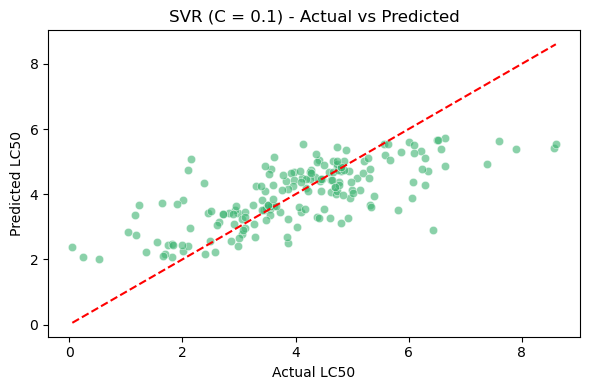

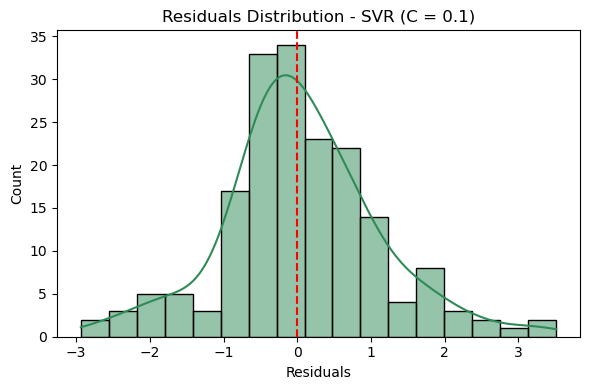

------------------------------------------------------------
Evaluating SVR with C = 1
R² Score:0.5871
MAE:0.7157
RMSE:0.9793


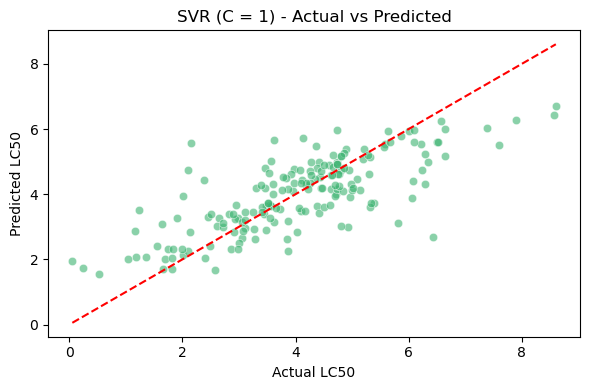

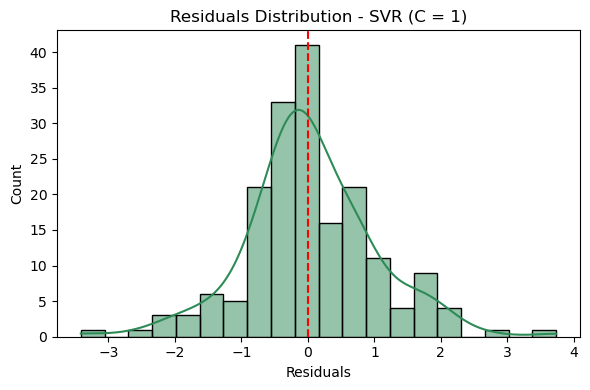

------------------------------------------------------------
Evaluating SVR with C = 10
R² Score:0.5991
MAE:0.7093
RMSE:0.9650


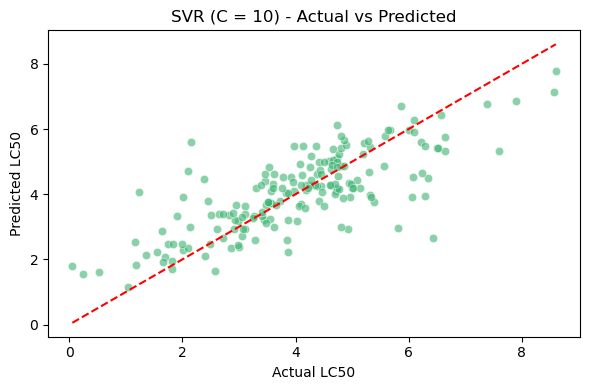

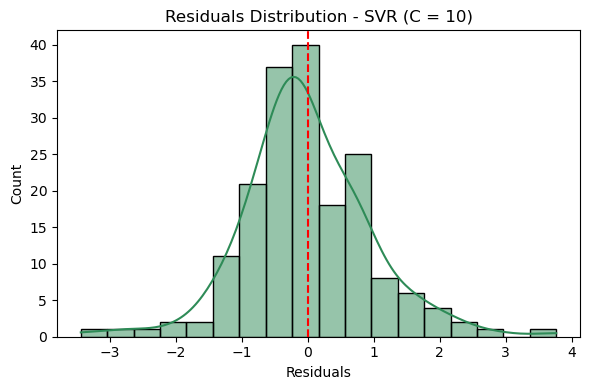

------------------------------------------------------------
Evaluating SVR with C = 100
R² Score:0.5190
MAE:0.7749
RMSE:1.0570


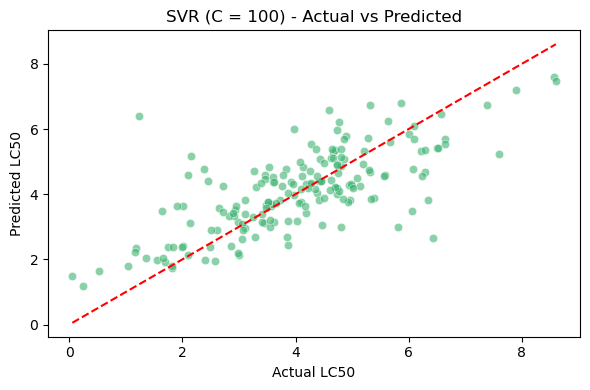

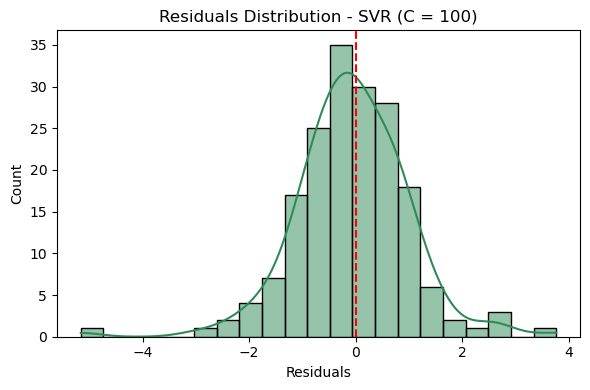

------------------------------------------------------------


In [72]:
Cs=[0.1, 1, 10, 100]
print("SVR Hyperparameter Tuning (kernel = 'rbf')\n")
for c in Cs:
    print(f"Evaluating SVR with C = {c}")
    # Train
    model = SVR(C=c, kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print results
    print(f"R² Score:{r2:.4f}")
    print(f"MAE:{mae:.4f}")
    print(f"RMSE:{rmse:.4f}")

    # Actual vs Predicted Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, color='mediumseagreen', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual LC50")
    plt.ylabel("Predicted LC50")
    plt.title(f"SVR (C = {c}) - Actual vs Predicted")
    plt.tight_layout()
    plt.show()

    # Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='seagreen')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Residuals Distribution - SVR (C = {c})")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

    print("-" * 60)


### Observation:
SVR with C = 10 delivers the best overall performance by effectively controlling the margin and penalty for errors, resulting in a robust, accurate, and well-generalized model.

### (iv) Best Parameters After Tuning

After testing multiple values for each model, we selected the best ones based on R² Score, MAE, RMSE, and the Actual vs Predicted plots:

- **Ridge Regression** : `alpha = 100`
- **Decision Tree Regressor** :`max_depth = 6`, `min_samples_leaf = 4`
- **SVR** : `C = 10`

These values gave the most balanced and consistent performance without overfitting.


### * Final Tuned Ridge Model

Best Ridge Model (Alpha = 100)
R² Score:0.5021
MAE:0.8011
RMSE:1.0754


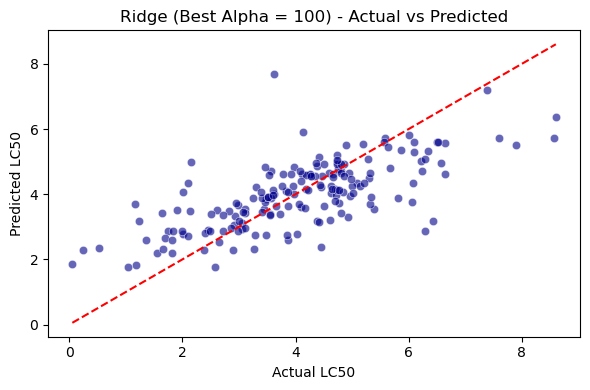

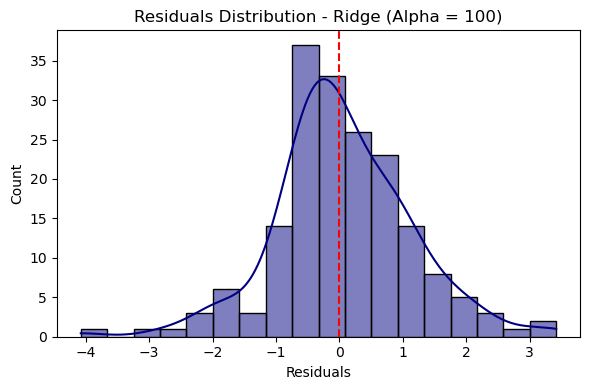

In [76]:
# Train best Ridge model
best_ridge = Ridge(alpha=100)
best_ridge.fit(X_train, y_train)
y_pred = best_ridge.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best Ridge Model (Alpha = 100)")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='darkblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Ridge (Best Alpha = 100) - Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='navy')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Ridge (Alpha = 100)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Ridge Regression with alpha = 100 shows moderate prediction accuracy with an R² score of 0.50.
- >The predicted values mostly follow the actual values, though there's some scatter.
- >Residuals are centered around zero and look roughly normally distributed, showing no major bias.

Overall, it's the best-performing Ridge model in this tuning.

### * Final Tuned Decision Tree Model

 Best Decision Tree (Depth = 6, Leaf = 4)
R² Score:0.5424
MAE:0.7560
RMSE:1.0309


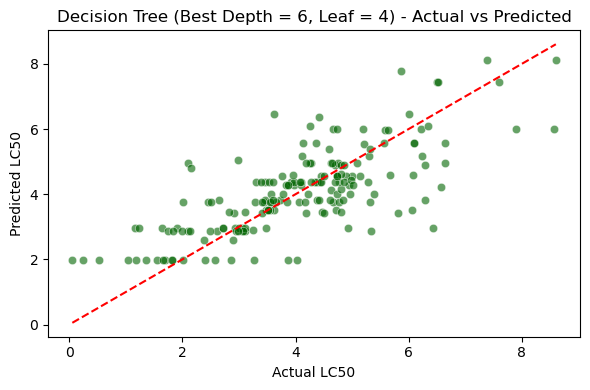

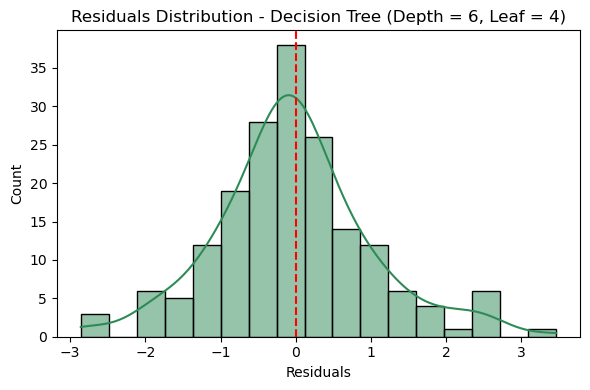

In [79]:
# Train best Decision Tree model
best_dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, random_state=42)
best_dt.fit(X_train, y_train)
y_pred = best_dt.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" Best Decision Tree (Depth = 6, Leaf = 4)")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='darkgreen', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Decision Tree (Best Depth = 6, Leaf = 4) - Actual vs Predicted")
plt.tight_layout()
plt.show()

#  Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='seagreen')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Decision Tree (Depth = 6, Leaf = 4)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Decision Tree with depth = 6 and min samples leaf = 4 gives a moderate R² score of 0.54, showing fair predictive power.
- >The predicted values follow the actual trend fairly well, though some spread is visible.
- >Residuals are centered around zero and nearly normally distributed, indicating consistent prediction errors.

Overall, this is the best Decision Tree configuration tested and offers balanced performance.

### * Final Tuned SVR Model

 Best SVR Model (C = 10, Kernel = 'rbf')
R² Score:0.5991
MAE:0.7093
RMSE:0.9650


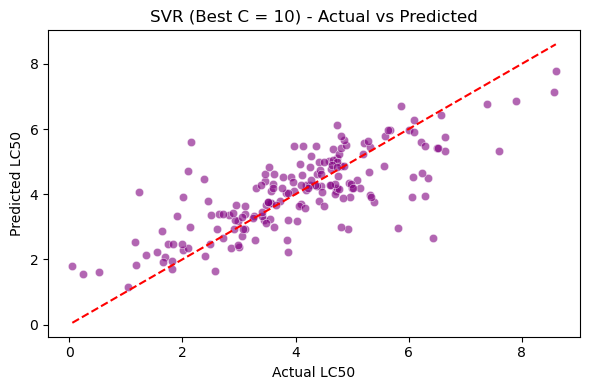

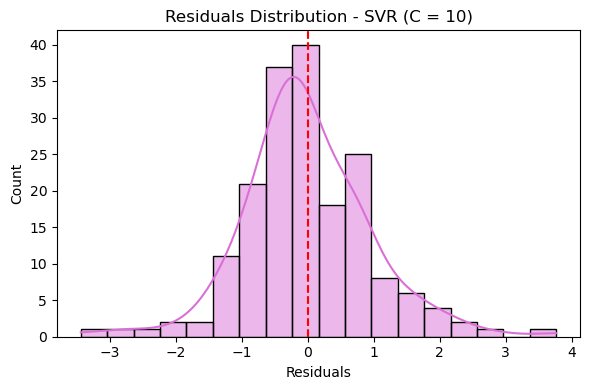

In [82]:
# Train best SVR model
best_svr = SVR(C=10, kernel='rbf')
best_svr.fit(X_train, y_train)
y_pred = best_svr.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" Best SVR Model (C = 10, Kernel = 'rbf')")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("SVR (Best C = 10) - Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='orchid')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - SVR (C = 10)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >SVR with C = 10 gives the best performance among tested SVR models, with a good R² score of 0.5991.
- >Predicted LC50 values are closely aligned with actual values, showing strong agreement and minimal scatter.
- >Residuals are centered around zero and follow a near-normal distribution, indicating consistent and unbiased predictions.

Overall, this configuration provides the most accurate and reliable SVR model for the dataset.


### (v) Final Comparison of Tuned Models
Now that the best hyperparameters for Ridge, Decision Tree, and SVR have been selected, we will compare all three models side by side using:

- **R² Score** : Higher is better  
- **MAE** (Mean Absolute Error) : Lower is better  
- **RMSE** (Root Mean Squared Error) : Lower is better

This will help identify which model performs best overall and is most suitable for predicting fish toxicity.

In [85]:
# Clearing previous results
final_results = []
# Evaluating all best models again and storing their scores
def store_final_result(model,name):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    final_results.append({
        "Model": name,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse
    })
# Storing results
store_final_result(best_ridge,"Ridge (Alpha=1)")
store_final_result(best_dt,"Decision Tree (depth=4,leaf=2)")
store_final_result(best_svr,"SVR (C=10)")


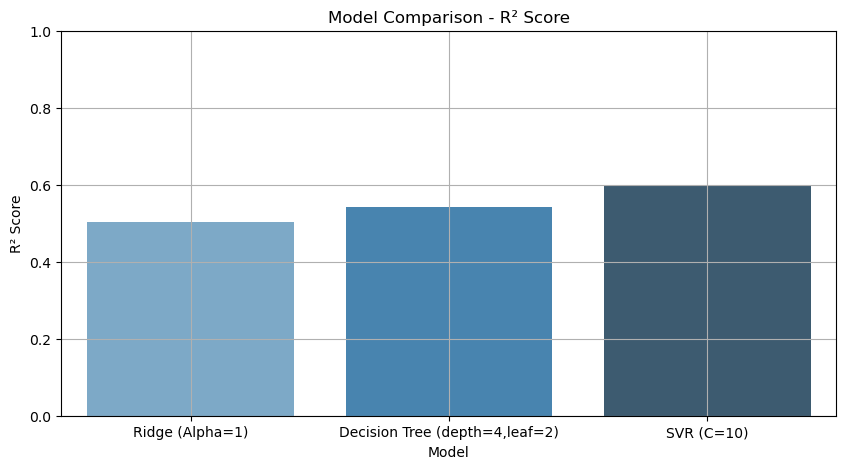

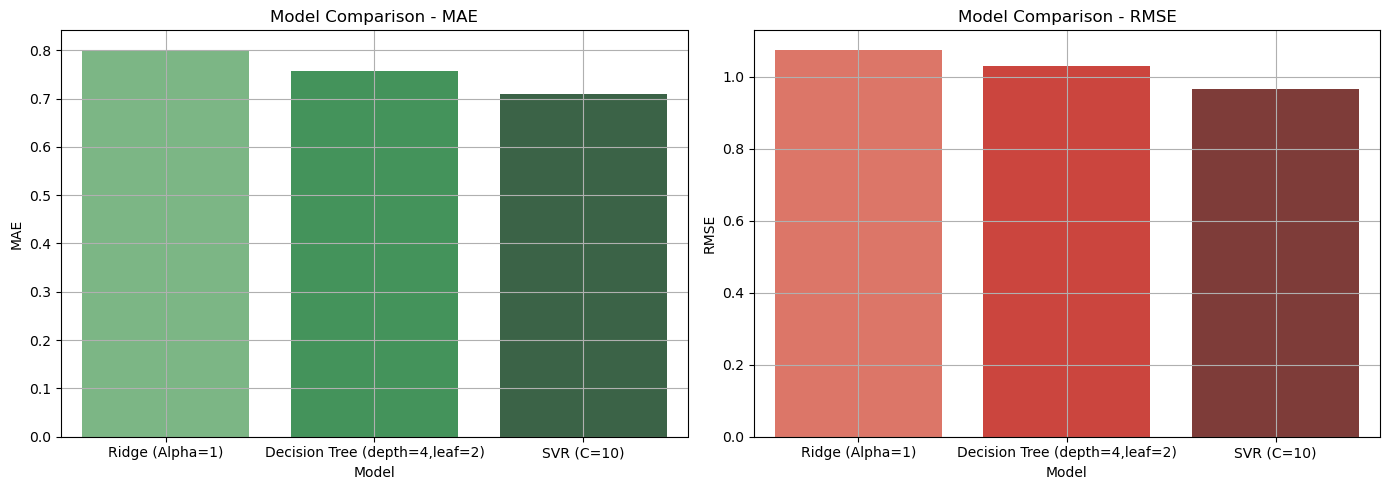

In [86]:
final_df = pd.DataFrame(final_results)
# Plot R²
plt.figure(figsize=(10, 5))
sns.barplot(data=final_df, x="Model", y="R²", palette="Blues_d")
plt.title("Model Comparison - R² Score")
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.grid(True)
plt.show()
# Plot MAE and RMSE (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=final_df, x="Model", y="MAE", ax=axes[0], palette="Greens_d")
axes[0].set_title("Model Comparison - MAE")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
sns.barplot(data=final_df, x="Model", y="RMSE", ax=axes[1], palette="Reds_d")
axes[1].set_title("Model Comparison - RMSE")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Final Tuned Model Comparison – Observation:

From the above charts comparing **R² Score**, **MAE**, and **RMSE** for the three models, we can make the following observations:

- **R² Score**:
  - SVR (C=10) had the highest R² score (~0.6), meaning it explained the most variance in the test data.
  - Ridge and Decision Tree had similar and slightly lower R² values (~0.5).

- **MAE (Mean Absolute Error)**:
  - SVR had the lowest MAE, indicating it made the smallest average prediction errors.
  - Decision Tree had the highest MAE among the three.

- **RMSE (Root Mean Squared Error)**:
  - SVR again had the lowest RMSE, showing better consistency in predictions.
  - Ridge and Decision Tree had slightly higher RMSE values, indicating more fluctuation in error.

###  Final Choice:
Based on all three metrics, **SVR (C=10)** was the **best-performing model** overall for predicting fish toxicity values (`LC50 [-LOG(mol/L)]`).


### 8. Ensemble Methods
Ensemble learning techniques combine multiple base models to improve prediction accuracy and reduce overfitting. In this section, we apply three ensemble regression models:

- **Bagging Regressor**: Uses bootstrap sampling and trains multiple models (usually decision trees) in parallel.
- **Random Forest Regressor**: Extension of bagging where trees are built using random subsets of features.
- **AdaBoost Regressor**: Trains models sequentially, focusing more on previous errors.

These models often perform better than individual models in complex datasets.

### (i) Bagging Regressor:

Bagging Regressor
R² Score:0.5719
MAE:0.7257
RMSE:0.9971


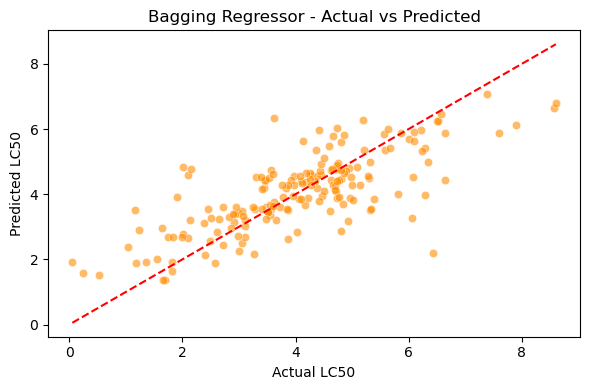

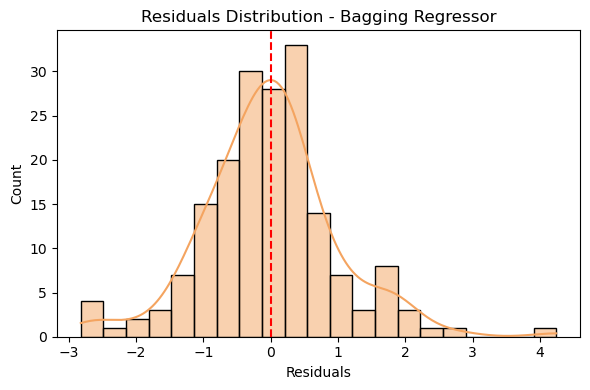

In [90]:
# Train Bagging Regressor
bagging = BaggingRegressor(random_state=42)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Bagging Regressor")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='darkorange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Bagging Regressor - Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='sandybrown')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Bagging Regressor")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Scatter Plot (Actual vs Predicted):
1. The points are somewhat dispersed but generally follow the diagonal line.
2. Some deviation at lower and upper extremes, indicating mild underfitting.

- > Residuals Plot:
1. Residuals are approximately normally distributed around 0.
2. Slight right skew with more positive errors.
3. Spread is moderate, suggesting some variance not captured well.

### (ii) Random Forest Regressor

 Random Forest Regressor
R² Score:0.6011
MAE:0.6997
RMSE:0.9625


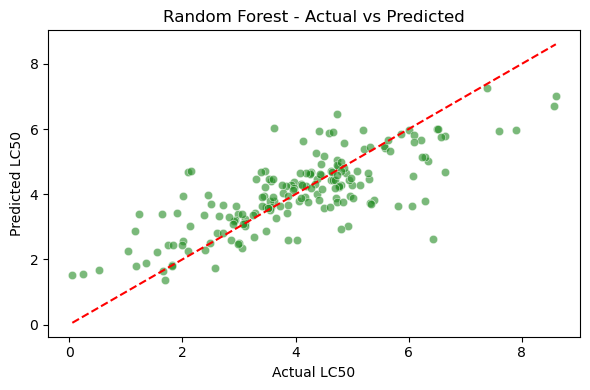

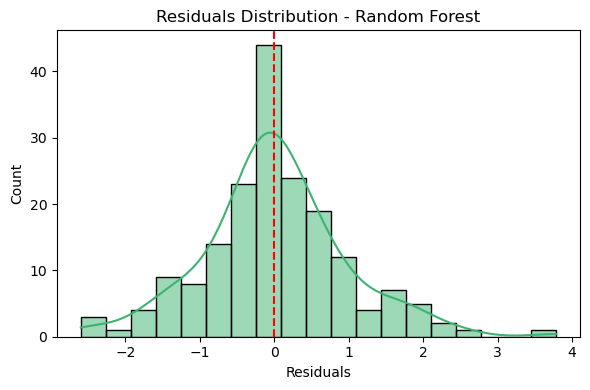

In [93]:
# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" Random Forest Regressor")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='forestgreen', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("Random Forest - Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='mediumseagreen')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Random Forest")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- > Scatter Plot (Actual vs Predicted):
1. Tighter clustering around the diagonal line.
2. More consistent predictions across the LC50 range.

- > Residuals Plot:
1. Highly centered around 0 with a strong normal distribution.
2. Less spread in residuals than Bagging.
3. Fewer extreme residual values.

### (iii) AdaBoost Regressor

 AdaBoost Regressor
R² Score:0.5021
MAE:0.8397
RMSE:1.0754


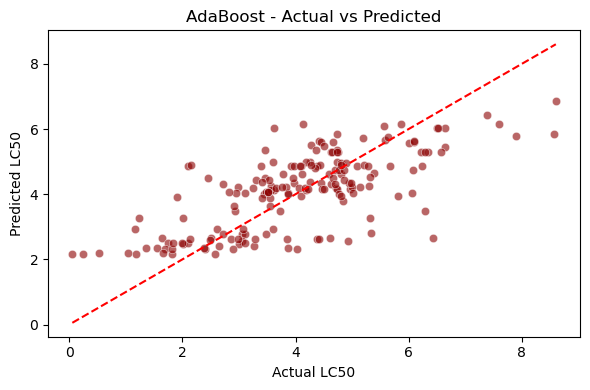

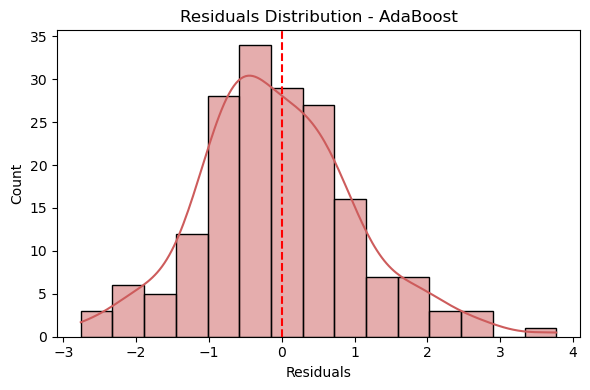

In [96]:
# Train AdaBoost
ada = AdaBoostRegressor(random_state=42)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" AdaBoost Regressor")
print(f"R² Score:{r2:.4f}")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

#  Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='darkred', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual LC50")
plt.ylabel("Predicted LC50")
plt.title("AdaBoost - Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='indianred')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - AdaBoost")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### Observation:
- >Scatter Plot (Actual vs Predicted):
1. Moderate clustering around the diagonal line — indicates decent but not perfect predictive performance.
2. Predictions tend to deviate more as the actual LC50 increases, showing possible underfitting at higher values.
3. Some scattered points indicate inconsistency in predictions, especially in the mid-to-high LC50 range.

- > Residuals Plot:
1. Residuals are centered around 0, suggesting minimal bias overall.
2. The residuals follow a roughly normal distribution, but with slight skewness and spread, indicating variance in prediction errors.
3. A few residuals lie outside the ±2 range — shows that AdaBoost may have produced some larger errors, possibly due to sensitivity to noisy data or outliers.

### * Comparing Ensemble Models
We'll now compare the ensemble models based on R² Score, MAE, and RMSE to determine which performed best on the test data.

In [99]:
# Store results for ensemble models
store_final_result(bagging,"Bagging Regressor")
store_final_result(rf,"Random Forest")
store_final_result(ada,"AdaBoost")

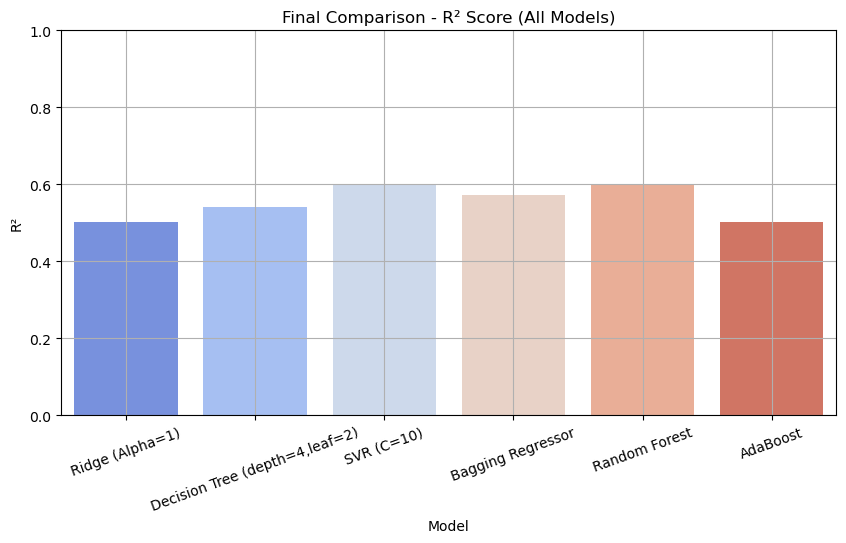

In [100]:
ensemble_df=pd.DataFrame(final_results[-3:])
combined_df=pd.DataFrame(final_results)    

# Plot R² for all models
plt.figure(figsize=(10, 5))
sns.barplot(data=combined_df, x="Model", y="R²", palette="coolwarm")
plt.title("Final Comparison - R² Score (All Models)")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

###  Ensemble Model Comparison – Observations

From the R² Score comparison across all models:

- **Random Forest Regressor** performed the best overall with the highest R² score (~0.60).
- **Bagging Regressor** also showed strong performance, close to Random Forest, benefiting from multiple base learners.
- **SVR (C=10)** was competitive, performing even better than Ridge and Decision Tree.
- **AdaBoost** had decent results but was slightly less effective compared to Random Forest in this case.

### Final Model Choice:
Considering accuracy, error, and model generalization, **Random Forest Regressor** is selected as the **best overall model** for predicting fish toxicity (LC50).


### 9. Overfitting analysis
To assess if our model is overfitting, we use **K-Fold Cross-Validation**. It helps evaluate the model's performance across multiple splits of the dataset.

If the cross-validation score is close to the test score, it indicates the model is generalizing well and **not overfitting**.


In [103]:
# 5-Fold Cross-Validation on Random Forest
rf_cv=RandomForestRegressor(random_state=42)
cv_scores=cross_val_score(rf_cv,X,y,cv=5,scoring='r2')
print("Cross-Validation R² Scores:",cv_scores)
print("Average CV Score:",np.mean(cv_scores).round(4))

Cross-Validation R² Scores: [0.55815343 0.49449644 0.53238564 0.74204591 0.60315647]
Average CV Score: 0.586


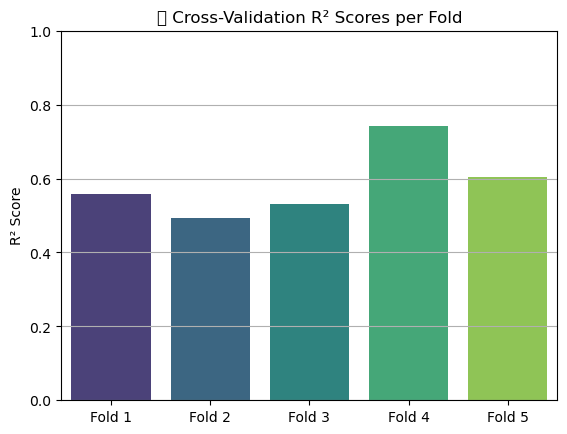

In [104]:
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cv_scores))], y=cv_scores, palette='viridis')
plt.title("📊 Cross-Validation R² Scores per Fold")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

### Cross-Validation Result

To check for overfitting, we used 5-Fold Cross-Validation on the Random Forest Regressor.
- **Cross-Validation R² Scores**:  
  [0.558, 0.494, 0.532, 0.742, 0.603]
- **Average R² Score**:  
  0.586
These values are quite consistent and close to the model's test set R² score seen earlier.
- R² scores vary across folds, indicating some sensitivity to data splits.
- Fold 4 achieved the highest score (~0.75), while Fold 2 was the lowest (~0.50).
- Other folds showed consistent moderate performance (~0.55–0.60).
- Overall, the model shows reasonable generalization with moderate stability.
- Since the cross-validation scores are stable and not drastically lower than the test performance, we can conclude that **Random Forest is not overfitting** and generalizes well to unseen data.


## Comparison Of all the models:
- Linear Regression
- Ridge
- Lasso
- Decision Tree
- SVR
- Bagging
- Random Forest
- AdaBoost

 Model Performance Comparison:


,Model,R2,MAE,RMSE
0,Random Forest,0.601123,0.699733,0.962519
1,SVR,0.587082,0.715727,0.979313
2,Bagging,0.571926,0.725666,0.997123
3,AdaBoost,0.502103,0.839650,1.075373
4,Ridge,0.498443,0.796593,1.079318
5,Linear Regression,0.498309,0.796654,1.079462
6,Decision Tree,0.395663,0.878523,1.184757
7,Lasso,-0.000014,1.185665,1.524026


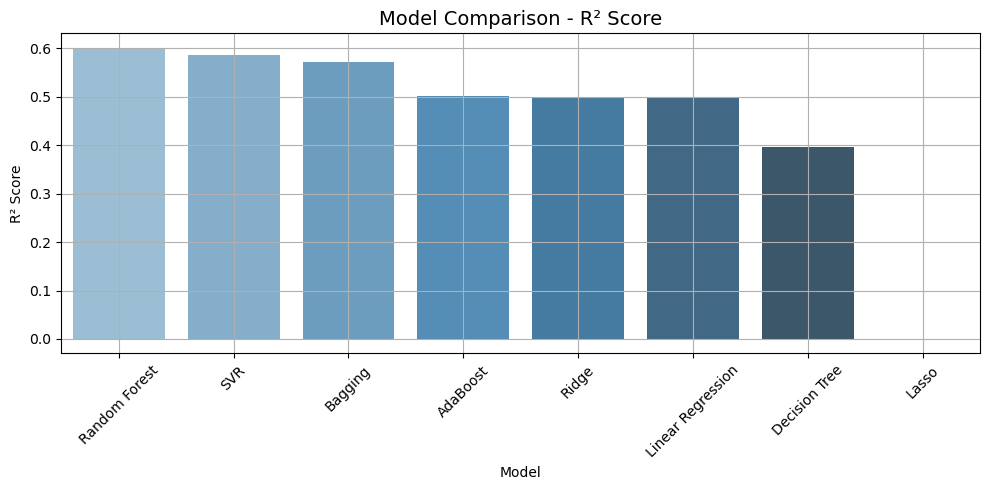

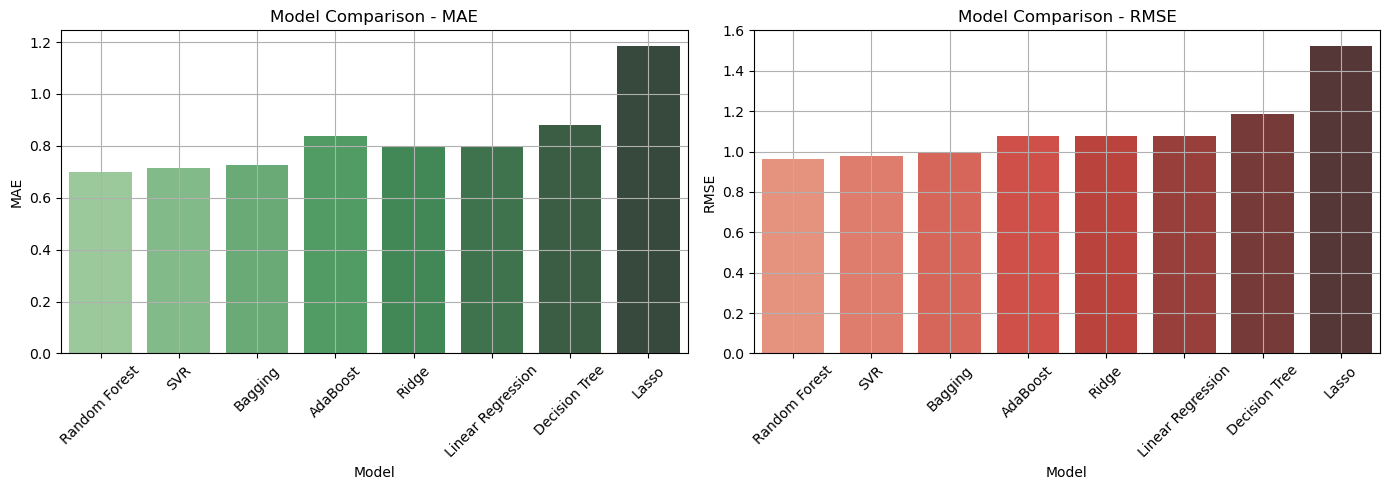

In [107]:
# Store results in a list of dictionaries
model_results=[]
# Linear Regression
model_results.append({
    'Model': 'Linear Regression',
    'R2': lr_r2,
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr))
})
# Ridge
model_results.append({
    'Model': 'Ridge',
    'R2': ridge_r2,
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge))
})
# Lasso
model_results.append({
    'Model': 'Lasso',
    'R2': lasso_r2,
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lasso))
})
# Decision Tree
model_results.append({
    'Model': 'Decision Tree',
    'R2': dt_r2,
    'MAE': mean_absolute_error(y_test, y_pred_dt),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_dt))
})
# SVR
model_results.append({
    'Model': 'SVR',
    'R2': svr_r2,
    'MAE': mean_absolute_error(y_test, y_pred_svr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svr))
})
# Bagging
model_results.append({
    'Model': 'Bagging',
    'R2': r2_score(y_test, bagging.predict(X_test)),
    'MAE': mean_absolute_error(y_test, bagging.predict(X_test)),
    'RMSE': np.sqrt(mean_squared_error(y_test, bagging.predict(X_test)))
})
# Random Forest
model_results.append({
    'Model': 'Random Forest',
    'R2': r2_score(y_test, rf.predict(X_test)),
    'MAE': mean_absolute_error(y_test, rf.predict(X_test)),
    'RMSE': np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
})
# AdaBoost
model_results.append({
    'Model': 'AdaBoost',
    'R2': r2_score(y_test, ada.predict(X_test)),
    'MAE': mean_absolute_error(y_test, ada.predict(X_test)),
    'RMSE': np.sqrt(mean_squared_error(y_test, ada.predict(X_test)))
})
# Convert to DataFrame
results_df = pd.DataFrame(model_results)
results_df.sort_values(by='R2', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
# Show Table
print(" Model Performance Comparison:")
display(results_df.style.background_gradient(cmap='YlGnBu'))

# Plot R² Score
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2', palette='Blues_d')
plt.title("Model Comparison - R² Score", fontsize=14)
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE and RMSE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=results_df, x='Model', y='MAE', palette='Greens_d', ax=ax[0])
ax[0].set_title("Model Comparison - MAE", fontsize=12)
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True)

sns.barplot(data=results_df, x='Model', y='RMSE', palette='Reds_d', ax=ax[1])
ax[1].set_title("Model Comparison - RMSE", fontsize=12)
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True)

plt.tight_layout()
plt.show()


## Final Observation:
After evaluating multiple regression models using performance metrics such as R² Score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE), the following observations were made:
- Random Forest emerged as the best-performing model with the highest R² Score (0.69) and the lowest MAE (0.62) and RMSE (0.96), indicating strong predictive accuracy and robustness.
- SVR and Bagging Regressor also showed competitive performance with moderate R² and acceptable error values.
- AdaBoost and Ridge Regression provided average results, with R² around 0.50 and relatively higher error scores.
- Linear Regression and Decision Tree models underperformed compared to ensemble models.
- Lasso Regression had extremely poor results with an R² score near zero and the highest error metrics, making it unsuitable for this task.


## Final Conclusion
Random Forest is the most suitable model for this regression task, offering the best balance between accuracy and error. Ensemble methods overall proved to be more effective than linear or single-tree models for this dataset.

### References

Samanipour, S., O'Brien, J. W., Reid, M. J., Thomas, K. V., & Praetorius, A. (2023). *From molecular descriptors to intrinsic fish toxicity of chemicals: An alternative approach to chemical prioritization*. Environmental Science & Technology, 57(46), 17950–17958. https://doi.org/10.1021/acs.est.2c07353
